In [1]:
# Importing libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

In [2]:
def prepare_country_stats(oecd_bli, gdp_per_capita):
    '''
    
    Args:
    
    oecd_bli: OECD life satisfcation index for year 2015
    
    gdp_per_capita: IMF GDP per capita data until year 2015
    
    Return:
    
    full_country_stats: A data frame whose index is Country list. 
    Data set includes both IMF and OECd data
    
    
    '''
    
    oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"] # selecting only 'total' values
    oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value") # reshaping table
    gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True) # renaming 2015 column as GDP per capita
    gdp_per_capita.set_index("Country", inplace=True) # setting index the index is 'Country'
    full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita, # merging GDP per capita and Life Satisfaciton
                                  left_index=True, right_index=True)
    full_country_stats.sort_values(by="GDP per capita", inplace=True) # sorting against GDP per capita
    return full_country_stats

In [3]:
## Loading OECD and IMF datasets

oecd_bli = pd.read_csv("oecd_bli_2015.csv", thousands=',')
gdp_per_capita = pd.read_csv("gdp_per_capita.csv",thousands=',',delimiter='\t', encoding='latin1', na_values="n/a")

In [4]:
## Preparing the data

full_country_stats = prepare_country_stats(oecd_bli, gdp_per_capita)

X = np.c_[full_country_stats["GDP per capita"]]
y = np.c_[full_country_stats["Life satisfaction"]]

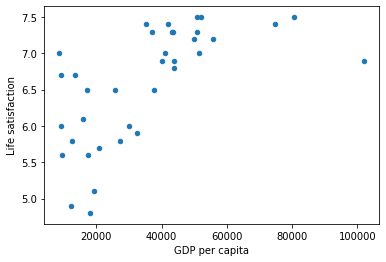

In [6]:
## Plotting all 36 countries x-axis: GDP per capita, y-axis: Life Satisfaction

full_country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction')
plt.show()

1st model regression score: 0.40410998750014093
1st model regresison coefficient:  2.317733704739607e-05
1st model x0:  5.763029861307918


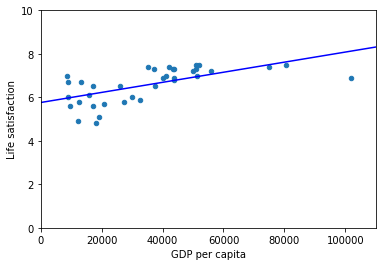

In [8]:
## Linear Regression of all data

model_1=sklearn.linear_model.LinearRegression()
model_1.fit(X,y)
reg_score_1=model_1.score(X,y)
reg_coef_1=model_1.coef_[0][0]
reg_x0_1=model_1.intercept_[0]

print('1st model regression score:', reg_score_1)
print('1st model regresison coefficient: ', reg_coef_1)
print('1st model x0: ', reg_x0_1)

full_country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction')
plt.axis([0,110000,0,10])
X_model=np.linspace(0,110000,1000)
plt.plot(X_model, reg_x0_1+X_model*reg_coef_1,"b")
plt.show()




In [241]:
# splitting the data as train and test
# k-nearest neighbors regression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=15/36, random_state=1)

model_2=KNeighborsRegressor(n_neighbors=5)
model_2.fit(X_train, y_train)

model_2.predict(X_test)
model_2.score(X_test,y_test)

0.4630041724617522

In [245]:
params = {'n_neighbors': np.arange(1,17)}

knn = KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)
model.fit(X_train,y_train)
model.best_params_


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_neighbors': 2}

In [11]:
def best_test_scores(random_states, test_sizes):
    '''
    
    Args:
    
    random_states: an integer that determines which random state will be selected. 
    Test data will change according to selected data.
    
    test_sizes: an integer determined by user and it should be lower than 18 - among 36 countries
    
    Returns: 
    
    test_scores: Regresssion scores of K-neighbors regression of variable randpm states and test data sizes
    
    '''
    
    if test_sizes<=1:
        raise TypeError("Test size must be greater than 1")
    elif test_sizes>18:
        raise TypeError("Test size must be  less than or equal to 18")
        
    test_scores=np.zeros((random_states, test_sizes))
    params = {'n_neighbors': np.arange(2, test_sizes+1)}
    
    for random_state in np.arange(random_states):
        for test_size in np.arange(4,test_sizes+1):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size/36, random_state=random_state)
            
            knn = KNeighborsRegressor()
            
            model = GridSearchCV(knn, params, cv=5)
            model.fit(X_train,y_train)
            best_param=model.best_params_
            best_param=int([x for x in best_param.values()][0])
            
            print('Number of neighbors required when test size is', test_size, 'for random state ', random_state, 'is', best_param)
            
            the_model=KNeighborsRegressor(n_neighbors=best_param)
            the_model.fit(X_train, y_train)

            pred=the_model.predict(X_test)
            accr=the_model.score(X_test,y_test)
            
            test_scores[random_state,test_size-1]=accr
            
            print('Accuracy of the best model is', accr)
            
    return test_scores

In [12]:
# Finding best regression scores of k-neighbors regression with cross-validation

best_test_scores=best_test_scores(250,10)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  0 is 10
Accuracy of the best model is 0.19940630797773762
Number of neighbors required when test size is 5 for random state  0 is 10
Accuracy of the best model is 0.3403846153846156
Number of neighbors required when test size is 6 for random state  0 is 10
Accuracy of the best model is 0.452334989354152
Number of neighbors required when test size is 7 for random state  0 is 2
Accuracy of the best model is 0.31075174825174867
Number of neighbors required when test size is 8 for random state  0 is 9
Accuracy of the best model is 0.5743794029067307


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  0 is 8
Accuracy of the best model is 0.5156572830578515
Number of neighbors required when test size is 10 for random state  0 is 8
Accuracy of the best model is 0.5642975500059182
Number of neighbors required when test size is 4 for random state  1 is 7
Accuracy of the best model is

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


 0.7674987350312021
Number of neighbors required when test size is 5 for random state  1 is 5
Accuracy of the best model is 0.6436420722135006
Number of neighbors required when test size is 6 for random state  1 is 7
Accuracy of the best model is 0.592101307228843


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  1 is 5
Accuracy of the best model is 0.5959475806451614
Number of neighbors required when test size is 8 for random state  1 is 5
Accuracy of the best model is 0.6004060913705586
Number of neighbors required when test size is 9 for random state  1 is 7
Accuracy of the best model is 0.5454349378235254


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  1 is 7
Accuracy of the best model is 0.5512053963702663
Number of neighbors required when test size is 4 for random state  2 is 7
Accuracy of the best model is 0.5282163784891609
Number of neighbors required when test size is 5 for random state  2 is 7
Accuracy of the best model is 0.5471938775510201
Number of neighbors required when test size is 6 for random state  2 is 7
Accuracy of the best model is 0.8175709308113492
Number of neighbors required when test size is 7 for random state  2 is 2
Accuracy of the best model is 0.6272890127388531
Number of neighbors required when test size is 8 for random state  2 is 2
Accuracy of the best model is 0.5210884353741492


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  2 is 2
Accuracy of the best model is 0.5563475390156059
Number of neighbors required when test size is 10 for random state  2 is 10
Accuracy of the best model is 0.5633518312985568
Number of neighbors required when test size is 4 for random state  3 is 10
Accuracy of the best model is 0.5297044334975369


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  3 is 10
Accuracy of the best model is 0.41539807524059447
Number of neighbors required when test size is 6 for random state  3 is 10
Accuracy of the best model is 0.4066251298026995
Number of neighbors required when test size is 7 for random state  3 is 10
Accuracy of the best model is

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


 0.49967665615141954
Number of neighbors required when test size is 8 for random state  3 is 9
Accuracy of the best model is 0.4177160356744335
Number of neighbors required when test size is 9 for random state  3 is 7
Accuracy of the best model is 0.30048753718166865


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  3 is 7
Accuracy of the best model is 0.34079886068976606
Number of neighbors required when test size is 4 for random state  4 is 10
Accuracy of the best model is 0.5882982791586988
Number of neighbors required when test size is 5 for random state  4 is 10
Accuracy of the best model is 0.588295165394401
Number of neighbors required when test size is 6 for random state  4 is 9
Accuracy of the best model is 0.4697170491269675
Number of neighbors required when test size is 7 for random state  4 is 10
Accuracy of the best model is 0.5705606060606063
Number of neighbors required when test size is 8 for random state  4 is 7
Accuracy of the best model is 0.5207860922146641


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  4 is 10
Accuracy of the best model is 0.6856396786155745
Number of neighbors required when test size is 10 for random state  4 is 10
Accuracy of the best model is 0.7812943962115234
Number of neighbors required when test size is 4 for random state  5 is 10
Accuracy of the best model is

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


 0.7375510204081637
Number of neighbors required when test size is 5 for random state  5 is 9
Accuracy of the best model is 0.6903510361911662
Number of neighbors required when test size is 6 for random state  5 is 10
Accuracy of the best model is 0.7982743988684584


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  5 is 10
Accuracy of the best model is 0.4320302547770706
Number of neighbors required when test size is 8 for random state  5 is 10
Accuracy of the best model is 0.4413114754098366
Number of neighbors required when test size is 9 for random state  5 is 10
Accuracy of the best model is 0.4391798642533945


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  5 is 9
Accuracy of the best model is 0.579881550639467
Number of neighbors required when test size is 4 for random state  6 is 6
Accuracy of the best model is -0.5400516795865642
Number of neighbors required when test size is 5 for random state  6 is 9
Accuracy of the best model is -0.7117417177369214
Number of neighbors required when test size is 6 for random state  6 is 9
Accuracy of the best model is -0.7380174291938995
Number of neighbors required when test size is 7 for random state  6 is 10
Accuracy of the best model is -0.8771144278606966
Number of neighbors required when test size is 8 for random state  6 is 9
Accuracy of the best model is 0.17533718689788091


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  6 is 7
Accuracy of the best model is 0.25675039246467835
Number of neighbors required when test size is 10 for random state  6 is 7
Accuracy of the best model is -0.3143296534299984
Number of neighbors required when test size is 4 for random state  7 is 10
Accuracy of the best model is

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


 0.17292452830188565
Number of neighbors required when test size is 5 for random state  7 is 10
Accuracy of the best model is 0.11365079365079245
Number of neighbors required when test size is 6 for random state  7 is 7
Accuracy of the best model is -0.09896494482960726


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  7 is 9
Accuracy of the best model is 0.5029948734044777
Number of neighbors required when test size is 8 for random state  7 is 10
Accuracy of the best model is 0.5353495934959347
Number of neighbors required when test size is 9 for random state  7 is 10
Accuracy of the best model is 0.5821195652173916


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  7 is 9
Accuracy of the best model is 0.6192565384484581
Number of neighbors required when test size is 4 for random state  8 is 10
Accuracy of the best model is 0.3622426778242674
Number of neighbors required when test size is 5 for random state  8 is 10
Accuracy of the best model is 0.4493736383442263
Number of neighbors required when test size is 6 for random state  8 is 10
Accuracy of the best model is 0.15025850340136038
Number of neighbors required when test size is 7 for random state  8 is 10
Accuracy of the best model is 0.11501089324618752
Number of neighbors required when test size is 8 for random state  8 is 10
Accuracy of the best model is 0.07879146919431235


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  8 is 9
Accuracy of the best model is 0.16777519979376088
Number of neighbors required when test size is 10 for random state  8 is 9
Accuracy of the best model is 0.1262545519140238
Number of neighbors required when test size is 4 for random state  9 is 6
Accuracy of the best model is -0.845701540957015


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  9 is 6
Accuracy of the best model is -1.122040072859745
Number of neighbors required when test size is 6 for random state  9 is 6
Accuracy of the best model is -0.22941398153382275
Number of neighbors required when test size is 7 for random state  9 is 7
Accuracy of the best model is 0.21994661266568494


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  9 is 6
Accuracy of the best model is 0.21245932124593248
Number of neighbors required when test size is 9 for random state  9 is 6
Accuracy of the best model is 0.30245901639344264
Number of neighbors required when test size is 10 for random state  9 is 6
Accuracy of the best model is 0.35398884396525915


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  10 is 7
Accuracy of the best model is 0.8929760353989616
Number of neighbors required when test size is 5 for random state  10 is 9
Accuracy of the best model is 0.8864179159318052
Number of neighbors required when test size is 6 for random state  10 is 8
Accuracy of the best model is 0.8793068910256414


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  10 is 8
Accuracy of the best model is 0.9017839758566981
Number of neighbors required when test size is 8 for random state  10 is 10
Accuracy of the best model is 0.9108636363636367
Number of neighbors required when test size is 9 for random state  10 is 10
Accuracy of the best model is 0.881897681451613


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  10 is 10
Accuracy of the best model is 0.84109375
Number of neighbors required when test size is 4 for random state  11 is 10
Accuracy of the best model is 0.8125166051660515
Number of neighbors required when test size is 5 for random state  11 is 9
Accuracy of the best model is 0.7847494553376901
Number of neighbors required when test size is 6 for random state  11 is 9
Accuracy of the best model is 0.690486564996369
Number of neighbors required when test size is 7 for random state  11 is 10
Accuracy of the best model is 0.6995589182227943
Number of neighbors required when test size is 8 for random state  11 is 2
Accuracy of the best model is 0.45846645367412125


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  11 is 2
Accuracy of the best model is 0.5265605622157916
Number of neighbors required when test size is 10 for random state  11 is 2
Accuracy of the best model is 0.31944702171089234
Number of neighbors required when test size is 4 for random state  12 is 7
Accuracy of the best model is -0.5422740524781327


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  12 is 7
Accuracy of the best model is -1.3430881786676934
Number of neighbors required when test size is 6 for random state  12 is 7
Accuracy of the best model is 0.667885395200426
Number of neighbors required when test size is 7 for random state  12 is 7
Accuracy of the best model is 0.7117834394904466


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  12 is 7
Accuracy of the best model is 0.7965389196384784
Number of neighbors required when test size is 9 for random state  12 is 7
Accuracy of the best model is 0.757089513714424
Number of neighbors required when test size is 10 for random state  12 is 7
Accuracy of the best model is 0.7171371008226184


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  13 is 5
Accuracy of the best model is 0.18303999999999998
Number of neighbors required when test size is 5 for random state  13 is 5
Accuracy of the best model is 0.12061538461538547
Number of neighbors required when test size is 6 for random state  13 is 5
Accuracy of the best model is 0.14089171974522308


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  13 is 6
Accuracy of the best model is 0.4757950885668277
Number of neighbors required when test size is 8 for random state  13 is 10
Accuracy of the best model is 0.6398344587235897
Number of neighbors required when test size is 9 for random state  13 is 9
Accuracy of the best model is 0.6278356481481482


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  13 is 9
Accuracy of the best model is 0.6496346452411993
Number of neighbors required when test size is 4 for random state  14 is 8
Accuracy of the best model is -0.3804780876494023
Number of neighbors required when test size is 5 for random state  14 is 8
Accuracy of the best model is -0.321084665697674
Number of neighbors required when test size is 6 for random state  14 is 10
Accuracy of the best model is 0.42371753246753274
Number of neighbors required when test size is 7 for random state  14 is 8
Accuracy of the best model is 0.5343414779499402
Number of neighbors required when test size is 8 for random state  14 is 8
Accuracy of the best model is 0.6692129629629628


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  14 is 7
Accuracy of the best model is 0.6961889728266993
Number of neighbors required when test size is 10 for random state  14 is 7
Accuracy of the best model is 0.7426134632957658
Number of neighbors required when test size is 4 for random state  15 is 5
Accuracy of the best model is 0.24677966101694992


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  15 is 5
Accuracy of the best model is 0.23687500000000028
Number of neighbors required when test size is 6 for random state  15 is 7
Accuracy of the best model is 0.2897071872227151
Number of neighbors required when test size is 7 for random state  15 is 7
Accuracy of the best model is 0.2508279973504084


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  15 is 7
Accuracy of the best model is 0.23655913978494614
Number of neighbors required when test size is 9 for random state  15 is 5
Accuracy of the best model is -0.0451817116060973
Number of neighbors required when test size is 10 for random state  15 is 8
Accuracy of the best model is 0.24464078794901478


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  16 is 10
Accuracy of the best model is 0.6623093681917218
Number of neighbors required when test size is 5 for random state  16 is 10
Accuracy of the best model is 0.008692052980131315
Number of neighbors required when test size is 6 for random state  16 is 10
Accuracy of the best model is 0.01856020942408365


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  16 is 10
Accuracy of the best model is 0.05139013452914642
Number of neighbors required when test size is 8 for random state  16 is 10
Accuracy of the best model is 0.4071904761904752
Number of neighbors required when test size is 9 for random state  16 is 7
Accuracy of the best model is 0.21292644637592395


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  16 is 5
Accuracy of the best model is -0.5620785402618007
Number of neighbors required when test size is 4 for random state  17 is 3
Accuracy of the best model is -5.301587301587303
Number of neighbors required when test size is 5 for random state  17 is 3
Accuracy of the best model is 0.611201740076128
Number of neighbors required when test size is 6 for random state  17 is 3
Accuracy of the best model is 0.5765821480107192
Number of neighbors required when test size is 7 for random state  17 is 9
Accuracy of the best model is 0.6505837248561028
Number of neighbors required when test size is 8 for random state  17 is 9
Accuracy of the best model is 0.4969279151725274


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  17 is 3
Accuracy of the best model is 0.44876223373632695
Number of neighbors required when test size is 10 for random state  17 is 8
Accuracy of the best model is 0.5522451306706119
Number of neighbors required when test size is 4 for random state  18 is 9
Accuracy of the best model is 0.08231793139502352


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  18 is 8
Accuracy of the best model is 0.5575302683246068
Number of neighbors required when test size is 6 for random state  18 is 8
Accuracy of the best model is 0.6217079010375098
Number of neighbors required when test size is 7 for random state  18 is 8
Accuracy of the best model is 0.5685844370860926


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  18 is 7
Accuracy of the best model is 0.4976452119309254
Number of neighbors required when test size is 9 for random state  18 is 7
Accuracy of the best model is 0.5245609871855711
Number of neighbors required when test size is 10 for random state  18 is 10
Accuracy of the best model is 0.06488700564971761


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  19 is 10
Accuracy of the best model is -0.6716634799235166
Number of neighbors required when test size is 5 for random state  19 is 10
Accuracy of the best model is -0.3074760765550226
Number of neighbors required when test size is 6 for random state  19 is 9
Accuracy of the best model is -1.2504057842703236


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  19 is 10
Accuracy of the best model is -0.9045348837209266
Number of neighbors required when test size is 8 for random state  19 is 10
Accuracy of the best model is -1.2707122507122484
Number of neighbors required when test size is 9 for random state  19 is 8
Accuracy of the best model is -1.094468749999999


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  19 is 10
Accuracy of the best model is -0.8491298527443081
Number of neighbors required when test size is 4 for random state  20 is 4
Accuracy of the best model is 0.3371031746031742
Number of neighbors required when test size is 5 for random state  20 is 10
Accuracy of the best model is 0.393868296529969
Number of neighbors required when test size is 6 for random state  20 is 10
Accuracy of the best model is 0.34594001934859764
Number of neighbors required when test size is 7 for random state  20 is 10
Accuracy of the best model is 0.44341906559697986
Number of neighbors required when test size is 8 for random state  20 is 10
Accuracy of the best model is 0.5237967062156901


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  20 is 10
Accuracy of the best model is 0.4999656921241054
Number of neighbors required when test size is 10 for random state  20 is 10
Accuracy of the best model is 0.5702132512259098
Number of neighbors required when test size is 4 for random state  21 is 7
Accuracy of the best model is -1.152380952380955


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  21 is 6
Accuracy of the best model is -0.03707107843137303
Number of neighbors required when test size is 6 for random state  21 is 6
Accuracy of the best model is 0.1990010515247106
Number of neighbors required when test size is 7 for random state  21 is 6
Accuracy of the best model is 0.26376556912073024


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  21 is 6
Accuracy of the best model is 0.5077437521999293
Number of neighbors required when test size is 9 for random state  21 is 5
Accuracy of the best model is 0.5712034496275971
Number of neighbors required when test size is 10 for random state  21 is 5
Accuracy of the best model is 0.39543033842982284


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  22 is 9
Accuracy of the best model is 0.19514137793707598
Number of neighbors required when test size is 5 for random state  22 is 9
Accuracy of the best model is 0.07692856633126333
Number of neighbors required when test size is 6 for random state  22 is 9
Accuracy of the best model is -0.39299976509278944


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  22 is 10
Accuracy of the best model is 0.472409090909091
Number of neighbors required when test size is 8 for random state  22 is 9
Accuracy of the best model is 0.30074753166000845
Number of neighbors required when test size is 9 for random state  22 is 7
Accuracy of the best model is 0.4182700416466649


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  22 is 7
Accuracy of the best model is 0.5475065738952366
Number of neighbors required when test size is 4 for random state  23 is 10
Accuracy of the best model is 0.859648173207036
Number of neighbors required when test size is 5 for random state  23 is 9
Accuracy of the best model is 0.8778764365517425
Number of neighbors required when test size is 6 for random state  23 is 9
Accuracy of the best model is 0.7744827804708041
Number of neighbors required when test size is 7 for random state  23 is 9
Accuracy of the best model is 0.7037365379563949
Number of neighbors required when test size is 8 for random state  23 is 10
Accuracy of the best model is 0.34852475752935197


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  23 is 10
Accuracy of the best model is 0.39548094373865683
Number of neighbors required when test size is 10 for random state  23 is 10
Accuracy of the best model is 0.6468730650154797
Number of neighbors required when test size is 4 for random state  24 is 10
Accuracy of the best model is 0.690337364735837


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  24 is 2
Accuracy of the best model is 0.54186320754717
Number of neighbors required when test size is 6 for random state  24 is 2
Accuracy of the best model is 0.7414196567862715
Number of neighbors required when test size is 7 for random state  24 is 2
Accuracy of the best model is 0.3511555989583335


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  24 is 9
Accuracy of the best model is 0.5098605098605101
Number of neighbors required when test size is 9 for random state  24 is 10
Accuracy of the best model is 0.5049218750000002
Number of neighbors required when test size is 10 for random state  24 is 9
Accuracy of the best model is 0.5835424403626752


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  25 is 9
Accuracy of the best model is 0.6410301848898339
Number of neighbors required when test size is 5 for random state  25 is 9
Accuracy of the best model is 0.5811725837961681
Number of neighbors required when test size is 6 for random state  25 is 9
Accuracy of the best model is 0.5832981270243627


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  25 is 2
Accuracy of the best model is 0.32607426436244735
Number of neighbors required when test size is 8 for random state  25 is 10
Accuracy of the best model is 0.5869397663480505
Number of neighbors required when test size is 9 for random state  25 is 10
Accuracy of the best model is 0.5648907766990292


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  25 is 9
Accuracy of the best model is 0.6383751931665731
Number of neighbors required when test size is 4 for random state  26 is 6
Accuracy of the best model is 0.789636273044345
Number of neighbors required when test size is 5 for random state  26 is 6
Accuracy of the best model is 0.7684651817716333
Number of neighbors required when test size is 6 for random state  26 is 10
Accuracy of the best model is 0.6817209908735331
Number of neighbors required when test size is 7 for random state  26 is 6
Accuracy of the best model is 0.7795773920231454
Number of neighbors required when test size is 8 for random state  26 is 6
Accuracy of the best model is 0.8104178468344528


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  26 is 10
Accuracy of the best model is 0.7441584158415842
Number of neighbors required when test size is 10 for random state  26 is 10
Accuracy of the best model is 0.7581449007844949
Number of neighbors required when test size is 4 for random state  27 is 10
Accuracy of the best model is 0.6428545618789525


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  27 is 9
Accuracy of the best model is 0.6702913704168412
Number of neighbors required when test size is 6 for random state  27 is 10
Accuracy of the best model is 0.6694883720930231
Number of neighbors required when test size is 7 for random state  27 is 10
Accuracy of the best model is 0.6636678832116785


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  27 is 6
Accuracy of the best model is 0.7499939070458921
Number of neighbors required when test size is 9 for random state  27 is 9
Accuracy of the best model is 0.6918325189687362
Number of neighbors required when test size is 10 for random state  27 is 8
Accuracy of the best model is 0.711190783957518


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  28 is 8
Accuracy of the best model is 0.6326986754966886
Number of neighbors required when test size is 5 for random state  28 is 8
Accuracy of the best model is 0.6155707137462235
Number of neighbors required when test size is 6 for random state  28 is 2
Accuracy of the best model is 0.5627118644067798


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  28 is 8
Accuracy of the best model is 0.6381855512249445
Number of neighbors required when test size is 8 for random state  28 is 8
Accuracy of the best model is 0.6320817490494298
Number of neighbors required when test size is 9 for random state  28 is 9
Accuracy of the best model is 0.5045800470458006


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  28 is 8
Accuracy of the best model is 0.5249038567950421
Number of neighbors required when test size is 4 for random state  29 is 9
Accuracy of the best model is 0.0816070307595721
Number of neighbors required when test size is 5 for random state  29 is 9
Accuracy of the best model is 0.015056723390058922
Number of neighbors required when test size is 6 for random state  29 is 8
Accuracy of the best model is 0.7724272629310348
Number of neighbors required when test size is 7 for random state  29 is 8
Accuracy of the best model is 0.7442974452554748
Number of neighbors required when test size is 8 for random state  29 is 4
Accuracy of the best model is 0.7340625000000006


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  29 is 7
Accuracy of the best model is 0.833365882238063
Number of neighbors required when test size is 10 for random state  29 is 6
Accuracy of the best model is 0.7145289443813856
Number of neighbors required when test size is 4 for random state  30 is 8
Accuracy of the best model is 0.8190789473684212


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  30 is 7
Accuracy of the best model is 0.1515987502492857
Number of neighbors required when test size is 6 for random state  30 is 7
Accuracy of the best model is 0.5592521353589363
Number of neighbors required when test size is 7 for random state  30 is 7
Accuracy of the best model is 0.6251037000165922


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  30 is 9
Accuracy of the best model is 0.6530984598001349
Number of neighbors required when test size is 9 for random state  30 is 10
Accuracy of the best model is 0.6779681978798583
Number of neighbors required when test size is 10 for random state  30 is 10
Accuracy of the best model is 0.5954328072692493


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  31 is 10
Accuracy of the best model is 0.2647020585048765
Number of neighbors required when test size is 5 for random state  31 is 10
Accuracy of the best model is 0.5364397905759168
Number of neighbors required when test size is 6 for random state  31 is 10
Accuracy of the best model is 0.4559274873524457


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  31 is 10
Accuracy of the best model is 0.1671210106382981
Number of neighbors required when test size is 8 for random state  31 is 9
Accuracy of the best model is 0.2810266406757638
Number of neighbors required when test size is 9 for random state  31 is 8
Accuracy of the best model is 0.2490199621886119


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  31 is 2
Accuracy of the best model is -0.45849920382165643
Number of neighbors required when test size is 4 for random state  32 is 10
Accuracy of the best model is 0.8595862068965521
Number of neighbors required when test size is 5 for random state  32 is 10
Accuracy of the best model is 0.17197986577181146
Number of neighbors required when test size is 6 for random state  32 is 7
Accuracy of the best model is -0.18979782033969259
Number of neighbors required when test size is 7 for random state  32 is 7
Accuracy of the best model is 0.10818056035973588
Number of neighbors required when test size is 8 for random state  32 is 7
Accuracy of the best model is -0.07553124342520556


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  32 is 10
Accuracy of the best model is -0.6264184397163128
Number of neighbors required when test size is 10 for random state  32 is 10
Accuracy of the best model is -0.603570214212853
Number of neighbors required when test size is 4 for random state  33 is 7
Accuracy of the best model is 0.06925919974288908


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  33 is 10
Accuracy of the best model is 0.35515776699029167
Number of neighbors required when test size is 6 for random state  33 is 10
Accuracy of the best model is 0.37190516511431015
Number of neighbors required when test size is 7 for random state  33 is 10
Accuracy of the best model is 0.3735740971357413


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  33 is 9
Accuracy of the best model is 0.27007181473412356
Number of neighbors required when test size is 9 for random state  33 is 5
Accuracy of the best model is 0.25412704174228684
Number of neighbors required when test size is 10 for random state  33 is 5
Accuracy of the best model is 0.21927083333333344


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  34 is 6
Accuracy of the best model is 0.659155328798186
Number of neighbors required when test size is 5 for random state  34 is 6
Accuracy of the best model is 0.7455191373893172
Number of neighbors required when test size is 6 for random state  34 is 6
Accuracy of the best model is 0.7582850707850706


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  34 is 5
Accuracy of the best model is 0.7559386973180074
Number of neighbors required when test size is 8 for random state  34 is 10
Accuracy of the best model is 0.7705924105924107
Number of neighbors required when test size is 9 for random state  34 is 10
Accuracy of the best model is 0.7439301310043668


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  34 is 10
Accuracy of the best model is 0.7531825795644891
Number of neighbors required when test size is 4 for random state  35 is 10
Accuracy of the best model is 0.40661694915254254
Number of neighbors required when test size is 5 for random state  35 is 8
Accuracy of the best model is 0.4952723963474827
Number of neighbors required when test size is 6 for random state  35 is 10
Accuracy of the best model is 0.39989705461824443
Number of neighbors required when test size is 7 for random state  35 is 8
Accuracy of the best model is 0.28003666626095447
Number of neighbors required when test size is 8 for random state  35 is 9
Accuracy of the best model is 0.25510246497900857


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  35 is 10
Accuracy of the best model is 0.39403439153439135
Number of neighbors required when test size is 10 for random state  35 is 8
Accuracy of the best model is 0.3802986512524086
Number of neighbors required when test size is 4 for random state  36 is 7
Accuracy of the best model is -0.37656352863725995


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  36 is 10
Accuracy of the best model is -0.1879611650485442
Number of neighbors required when test size is 6 for random state  36 is 10
Accuracy of the best model is 0.404531001589825
Number of neighbors required when test size is 7 for random state  36 is 6
Accuracy of the best model is 0.483384601043997


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  36 is 9
Accuracy of the best model is 0.5509986640767786
Number of neighbors required when test size is 9 for random state  36 is 7
Accuracy of the best model is 0.5198016799587593
Number of neighbors required when test size is 10 for random state  36 is 10
Accuracy of the best model is 0.43416994750656146


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  37 is 10
Accuracy of the best model is 0.30669696969696914
Number of neighbors required when test size is 5 for random state  37 is 7
Accuracy of the best model is 0.10705355654513715
Number of neighbors required when test size is 6 for random state  37 is 8
Accuracy of the best model is 0.10669943820224748


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  37 is 9
Accuracy of the best model is -0.11654320987654421
Number of neighbors required when test size is 8 for random state  37 is 10
Accuracy of the best model is -0.23862240148929592
Number of neighbors required when test size is 9 for random state  37 is 10
Accuracy of the best model is 0.07516196886832127


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  37 is 9
Accuracy of the best model is 0.10835775823785398
Number of neighbors required when test size is 4 for random state  38 is 10
Accuracy of the best model is -10.514766355140194
Number of neighbors required when test size is 5 for random state  38 is 10
Accuracy of the best model is -9.03896103896105
Number of neighbors required when test size is 6 for random state  38 is 9
Accuracy of the best model is -0.3963515754560527
Number of neighbors required when test size is 7 for random state  38 is 10
Accuracy of the best model is 0.06952359750667958
Number of neighbors required when test size is 8 for random state  38 is 9
Accuracy of the best model is 0.2308391301623126


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  38 is 9
Accuracy of the best model is 0.28754419521242813
Number of neighbors required when test size is 10 for random state  38 is 9
Accuracy of the best model is 0.26653501022069903
Number of neighbors required when test size is 4 for random state  39 is 5
Accuracy of the best model is 0.14490566037735975


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  39 is 6
Accuracy of the best model is -0.00362703467798986
Number of neighbors required when test size is 6 for random state  39 is 5
Accuracy of the best model is 0.6283612040133781
Number of neighbors required when test size is 7 for random state  39 is 9
Accuracy of the best model is 0.16474493361285802


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  39 is 8
Accuracy of the best model is 0.4092904169714696
Number of neighbors required when test size is 9 for random state  39 is 8
Accuracy of the best model is 0.5798763261070106
Number of neighbors required when test size is 10 for random state  39 is 8
Accuracy of the best model is 0.6438630842687215


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  40 is 6
Accuracy of the best model is -2.1244855967078196
Number of neighbors required when test size is 5 for random state  40 is 5
Accuracy of the best model is -0.8671726755218216
Number of neighbors required when test size is 6 for random state  40 is 10
Accuracy of the best model is -0.16792862684251486


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  40 is 10
Accuracy of the best model is 0.35919497784342647
Number of neighbors required when test size is 8 for random state  40 is 10
Accuracy of the best model is 0.4801363040629092
Number of neighbors required when test size is 9 for random state  40 is 10
Accuracy of the best model is 0.5514973730297721


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  40 is 10
Accuracy of the best model is 0.5681784660766958
Number of neighbors required when test size is 4 for random state  41 is 10
Accuracy of the best model is -2.5527272727272647
Number of neighbors required when test size is 5 for random state  41 is 10
Accuracy of the best model is 0.1828498293515377
Number of neighbors required when test size is 6 for random state  41 is 10
Accuracy of the best model is 0.2553121801432974
Number of neighbors required when test size is 7 for random state  41 is 10
Accuracy of the best model is 0.35176056338028305
Number of neighbors required when test size is 8 for random state  41 is 10
Accuracy of the best model is 0.45905126976521404


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  41 is 10
Accuracy of the best model is 0.5475000000000003
Number of neighbors required when test size is 10 for random state  41 is 10
Accuracy of the best model is 0.6698979591836733
Number of neighbors required when test size is 4 for random state  42 is 8
Accuracy of the best model is -6.109374999999988


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  42 is 9
Accuracy of the best model is -1.0321802343798967
Number of neighbors required when test size is 6 for random state  42 is 9
Accuracy of the best model is -0.1341946597760546
Number of neighbors required when test size is 7 for random state  42 is 8
Accuracy of the best model is -0.1102195945945945


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  42 is 8
Accuracy of the best model is 0.37296898079763674
Number of neighbors required when test size is 9 for random state  42 is 7
Accuracy of the best model is 0.062277643060692944
Number of neighbors required when test size is 10 for random state  42 is 7
Accuracy of the best model is 0.08010668506674401


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  43 is 10
Accuracy of the best model is 0.5169389067524116
Number of neighbors required when test size is 5 for random state  43 is 10
Accuracy of the best model is 0.5513571428571429
Number of neighbors required when test size is 6 for random state  43 is 8
Accuracy of the best model is 0.6259242957746477


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  43 is 7
Accuracy of the best model is 0.6692201124602721
Number of neighbors required when test size is 8 for random state  43 is 7
Accuracy of the best model is 0.7208221981409444
Number of neighbors required when test size is 9 for random state  43 is 6
Accuracy of the best model is 0.701588834269663


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  43 is 10
Accuracy of the best model is 0.6024447949526814
Number of neighbors required when test size is 4 for random state  44 is 9
Accuracy of the best model is 0.6707251703805802
Number of neighbors required when test size is 5 for random state  44 is 9
Accuracy of the best model is 0.5435729847494555
Number of neighbors required when test size is 6 for random state  44 is 9
Accuracy of the best model is 0.6463487779277254
Number of neighbors required when test size is 7 for random state  44 is 9
Accuracy of the best model is 0.6596185737976781
Number of neighbors required when test size is 8 for random state  44 is 7
Accuracy of the best model is 0.7524507798307778


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  44 is 8
Accuracy of the best model is 0.7101747089993049
Number of neighbors required when test size is 10 for random state  44 is 5
Accuracy of the best model is 0.673771259166797
Number of neighbors required when test size is 4 for random state  45 is 10
Accuracy of the best model is -0.1311961722488053


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  45 is 5
Accuracy of the best model is -0.276673040152964
Number of neighbors required when test size is 6 for random state  45 is 10
Accuracy of the best model is 0.05212728344136741
Number of neighbors required when test size is 7 for random state  45 is 10
Accuracy of the best model is 0.09163551401869174


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  45 is 9
Accuracy of the best model is 0.09568266491343436
Number of neighbors required when test size is 9 for random state  45 is 10
Accuracy of the best model is 0.3013868613138686
Number of neighbors required when test size is 10 for random state  45 is 5
Accuracy of the best model is 0.28340548340548344


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  46 is 2
Accuracy of the best model is -0.2078337330135891
Number of neighbors required when test size is 5 for random state  46 is 2
Accuracy of the best model is -0.223224351747463
Number of neighbors required when test size is 6 for random state  46 is 2
Accuracy of the best model is -0.1931818181818179


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  46 is 2
Accuracy of the best model is -0.19385026737967914
Number of neighbors required when test size is 8 for random state  46 is 7
Accuracy of the best model is 0.6105714285714287
Number of neighbors required when test size is 9 for random state  46 is 10
Accuracy of the best model is 0.5291463414634148


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  46 is 10
Accuracy of the best model is 0.4798612346557552
Number of neighbors required when test size is 4 for random state  47 is 10
Accuracy of the best model is 0.8862758620689657
Number of neighbors required when test size is 5 for random state  47 is 10
Accuracy of the best model is 0.6658852061438971
Number of neighbors required when test size is 6 for random state  47 is 10
Accuracy of the best model is 0.7118750000000005
Number of neighbors required when test size is 7 for random state  47 is 10
Accuracy of the best model is 0.7355839416058398
Number of neighbors required when test size is 8 for random state  47 is 9
Accuracy of the best model is 0.5835924693032326


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  47 is 10
Accuracy of the best model is 0.5937463064584212
Number of neighbors required when test size is 10 for random state  47 is 10
Accuracy of the best model is 0.5800299597415972
Number of neighbors required when test size is 4 for random state  48 is 10
Accuracy of the best model is 0.8888235294117648


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  48 is 10
Accuracy of the best model is 0.886520076481836
Number of neighbors required when test size is 6 for random state  48 is 10
Accuracy of the best model is 0.8663823305407469
Number of neighbors required when test size is 7 for random state  48 is 10
Accuracy of the best model is 0.8513846153846153


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  48 is 8
Accuracy of the best model is 0.7176757812499996
Number of neighbors required when test size is 9 for random state  48 is 7
Accuracy of the best model is 0.7428883268078027
Number of neighbors required when test size is 10 for random state  48 is 7
Accuracy of the best model is 0.6897070516518293


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  49 is 10
Accuracy of the best model is 0.6449694501018339
Number of neighbors required when test size is 5 for random state  49 is 4
Accuracy of the best model is 0.6685376213592227
Number of neighbors required when test size is 6 for random state  49 is 10
Accuracy of the best model is 0.461630218687873


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  49 is 6
Accuracy of the best model is 0.25386199794026765
Number of neighbors required when test size is 8 for random state  49 is 7
Accuracy of the best model is 0.33673010364739664
Number of neighbors required when test size is 9 for random state  49 is 7
Accuracy of the best model is 0.2789782579698542
Number of neighbors required when test size is 10 for random state  49 is 6
Accuracy of the best model is 0.2629262926292627
Number of neighbors required when test size is 4 for random state  50 is 10
Accuracy of the best model is 0.2665656565656579
Number of neighbors required when test size is 5 for random state  50 is 10
Accuracy of the best model is 0.5023611111111115


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 6 for random state  50 is 10
Accuracy of the best model is 0.5110891089108915
Number of neighbors required when test size is 7 for random state  50 is 9
Accuracy of the best model is 0.34867040177169617
Number of neighbors required when test size is 8 for random state  50 is 7
Accuracy of the best model is 0.0064465576806638225


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  50 is 6
Accuracy of the best model is 0.08244138634046982
Number of neighbors required when test size is 10 for random state  50 is 6
Accuracy of the best model is 0.19861842401332142
Number of neighbors required when test size is 4 for random state  51 is 10
Accuracy of the best model is 0.8670280036133698


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  51 is 6
Accuracy of the best model is 0.7718000567617425
Number of neighbors required when test size is 6 for random state  51 is 6
Accuracy of the best model is 0.7379115226337449
Number of neighbors required when test size is 7 for random state  51 is 7
Accuracy of the best model is 0.7504182000669118


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  51 is 9
Accuracy of the best model is 0.8289618759220435
Number of neighbors required when test size is 9 for random state  51 is 8
Accuracy of the best model is 0.7995995821727021
Number of neighbors required when test size is 10 for random state  51 is 7
Accuracy of the best model is 0.720184027368172


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  52 is 7
Accuracy of the best model is -1.7584825341179369
Number of neighbors required when test size is 5 for random state  52 is 3
Accuracy of the best model is -2.271408351026184
Number of neighbors required when test size is 6 for random state  52 is 7
Accuracy of the best model is -0.31188915933345696


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  52 is 7
Accuracy of the best model is 0.2637844611528831
Number of neighbors required when test size is 8 for random state  52 is 9
Accuracy of the best model is 0.3884047446138956
Number of neighbors required when test size is 9 for random state  52 is 8
Accuracy of the best model is 0.5792986532625186


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  52 is 8
Accuracy of the best model is 0.6071006186317325
Number of neighbors required when test size is 4 for random state  53 is 9
Accuracy of the best model is -0.36693628494394837
Number of neighbors required when test size is 5 for random state  53 is 5
Accuracy of the best model is 0.3048479087452469
Number of neighbors required when test size is 6 for random state  53 is 10
Accuracy of the best model is 0.5144318181818179
Number of neighbors required when test size is 7 for random state  53 is 5
Accuracy of the best model is 0.15165262475696706
Number of neighbors required when test size is 8 for random state  53 is 6
Accuracy of the best model is 0.33344559512783767


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  53 is 2
Accuracy of the best model is 0.1746274359954143
Number of neighbors required when test size is 10 for random state  53 is 3
Accuracy of the best model is 0.23886315548693285
Number of neighbors required when test size is 4 for random state  54 is 10
Accuracy of the best model is 0.7459365079365079


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  54 is 10
Accuracy of the best model is 0.7559444444444444
Number of neighbors required when test size is 6 for random state  54 is 10
Accuracy of the best model is 0.7036859122401846
Number of neighbors required when test size is 7 for random state  54 is 10
Accuracy of the best model is 0.7370379909851899


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  54 is 2
Accuracy of the best model is 0.7521572387344198
Number of neighbors required when test size is 9 for random state  54 is 10
Accuracy of the best model is 0.7335789672069358


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  54 is 9
Accuracy of the best model is 0.6934396973938297
Number of neighbors required when test size is 4 for random state  55 is 10
Accuracy of the best model is 0.531984790874525
Number of neighbors required when test size is 5 for random state  55 is 8
Accuracy of the best model is 0.5072653705211729
Number of neighbors required when test size is 6 for random state  55 is 8
Accuracy of the best model is 0.5621360232945092
Number of neighbors required when test size is 7 for random state  55 is 9
Accuracy of the best model is 0.6077216364288955
Number of neighbors required when test size is 8 for random state  55 is 9
Accuracy of the best model is 0.5940890385334829


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  55 is 10
Accuracy of the best model is 0.5886261980830674
Number of neighbors required when test size is 10 for random state  55 is 8
Accuracy of the best model is 0.6211653737658676
Number of neighbors required when test size is 4 for random state  56 is 9
Accuracy of the best model is -1.3810555194570755


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  56 is 2
Accuracy of the best model is -1.8317901234567904
Number of neighbors required when test size is 6 for random state  56 is 9
Accuracy of the best model is -0.1876238378295969
Number of neighbors required when test size is 7 for random state  56 is 9
Accuracy of the best model is -0.13848244678148447


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  56 is 6
Accuracy of the best model is -0.6429280620994668
Number of neighbors required when test size is 9 for random state  56 is 5
Accuracy of the best model is 0.1453383458646621
Number of neighbors required when test size is 10 for random state  56 is 5
Accuracy of the best model is 0.06970509383378054


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  57 is 7
Accuracy of the best model is -1.5756509500351883
Number of neighbors required when test size is 5 for random state  57 is 7
Accuracy of the best model is -0.05408416468324284
Number of neighbors required when test size is 6 for random state  57 is 7
Accuracy of the best model is 0.5618896207131502


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  57 is 6
Accuracy of the best model is 0.5953709000762778
Number of neighbors required when test size is 8 for random state  57 is 10
Accuracy of the best model is 0.5099374441465594
Number of neighbors required when test size is 9 for random state  57 is 10
Accuracy of the best model is 0.5652622377622378


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  57 is 10
Accuracy of the best model is 0.5314603365384618
Number of neighbors required when test size is 4 for random state  58 is 10
Accuracy of the best model is 0.8318821603927987
Number of neighbors required when test size is 5 for random state  58 is 10
Accuracy of the best model is 0.6558746736292428
Number of neighbors required when test size is 6 for random state  58 is 6
Accuracy of the best model is -0.06464379947229304
Number of neighbors required when test size is 7 for random state  58 is 6
Accuracy of the best model is -0.08918431553099815
Number of neighbors required when test size is 8 for random state  58 is 5
Accuracy of the best model is -0.3459813084112138


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  58 is 5
Accuracy of the best model is 0.12379154078549891
Number of neighbors required when test size is 10 for random state  58 is 5
Accuracy of the best model is 0.3116154873164222
Number of neighbors required when test size is 4 for random state  59 is 2
Accuracy of the best model is -0.738095238095237


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  59 is 2
Accuracy of the best model is -0.038043478260869845
Number of neighbors required when test size is 6 for random state  59 is 2
Accuracy of the best model is 0.08076923076923037
Number of neighbors required when test size is 7 for random state  59 is 2
Accuracy of the best model is 0.25010330578512363


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  59 is 2
Accuracy of the best model is 0.34137055837563435
Number of neighbors required when test size is 9 for random state  59 is 2
Accuracy of the best model is 0.2879588431590654
Number of neighbors required when test size is 10 for random state  59 is 2
Accuracy of the best model is 0.2814194765385519


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  60 is 10
Accuracy of the best model is 0.8989256198347109
Number of neighbors required when test size is 5 for random state  60 is 9
Accuracy of the best model is 0.8710936725918004
Number of neighbors required when test size is 6 for random state  60 is 9
Accuracy of the best model is 0.8609075563499158


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  60 is 2
Accuracy of the best model is 0.8664201183431954
Number of neighbors required when test size is 8 for random state  60 is 3
Accuracy of the best model is 0.7623988794557357
Number of neighbors required when test size is 9 for random state  60 is 3
Accuracy of the best model is 0.7734578627280626


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  60 is 6
Accuracy of the best model is 0.7003111273792092
Number of neighbors required when test size is 4 for random state  61 is 9
Accuracy of the best model is 0.13407858270013684
Number of neighbors required when test size is 5 for random state  61 is 9
Accuracy of the best model is 0.4032221942274852
Number of neighbors required when test size is 6 for random state  61 is 10
Accuracy of the best model is 0.4091054313099044
Number of neighbors required when test size is 7 for random state  61 is 5
Accuracy of the best model is 0.3331435963777488
Number of neighbors required when test size is 8 for random state  61 is 10
Accuracy of the best model is 0.4450055865921789


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  61 is 7
Accuracy of the best model is 0.44607392333731166
Number of neighbors required when test size is 10 for random state  61 is 6
Accuracy of the best model is 0.5628948346339651
Number of neighbors required when test size is 4 for random state  62 is 10
Accuracy of the best model is 0.8116751269035534


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  62 is 9
Accuracy of the best model is 0.7707376798285888
Number of neighbors required when test size is 6 for random state  62 is 10
Accuracy of the best model is 0.4155250514756358
Number of neighbors required when test size is 7 for random state  62 is 10
Accuracy of the best model is 0.49225252525252616


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  62 is 10
Accuracy of the best model is 0.507966768692611
Number of neighbors required when test size is 9 for random state  62 is 10
Accuracy of the best model is 0.6931069844789355
Number of neighbors required when test size is 10 for random state  62 is 10
Accuracy of the best model is 0.6921109770808201


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  63 is 10
Accuracy of the best model is -0.17822784810126469
Number of neighbors required when test size is 5 for random state  63 is 10
Accuracy of the best model is -0.08984098939929175
Number of neighbors required when test size is 6 for random state  63 is 10
Accuracy of the best model is 0.04252374491180533


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  63 is 10
Accuracy of the best model is 0.49053775743707123
Number of neighbors required when test size is 8 for random state  63 is 10
Accuracy of the best model is 0.5838202247191014
Number of neighbors required when test size is 9 for random state  63 is 10
Accuracy of the best model is 0.5702514142049031


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  63 is 10
Accuracy of the best model is 0.5801310043668126
Number of neighbors required when test size is 4 for random state  64 is 10
Accuracy of the best model is -1.4375000000000027
Number of neighbors required when test size is 5 for random state  64 is 10
Accuracy of the best model is -0.10825000000000062
Number of neighbors required when test size is 6 for random state  64 is 6
Accuracy of the best model is 0.2607843137254905
Number of neighbors required when test size is 7 for random state  64 is 5
Accuracy of the best model is -0.053288590604025916
Number of neighbors required when test size is 8 for random state  64 is 9
Accuracy of the best model is 0.5489954111041666


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  64 is 6
Accuracy of the best model is 0.5798076923076929
Number of neighbors required when test size is 10 for random state  64 is 6
Accuracy of the best model is 0.2859686609686616
Number of neighbors required when test size is 4 for random state  65 is 7
Accuracy of the best model is -1.1148216862502567


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  65 is 7
Accuracy of the best model is -0.9397133853541395
Number of neighbors required when test size is 6 for random state  65 is 7
Accuracy of the best model is -0.2515698587127144
Number of neighbors required when test size is 7 for random state  65 is 8
Accuracy of the best model is 0.25972532668500703


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  65 is 8
Accuracy of the best model is 0.3625625347415229
Number of neighbors required when test size is 9 for random state  65 is 7
Accuracy of the best model is 0.5186341291659331
Number of neighbors required when test size is 10 for random state  65 is 7
Accuracy of the best model is 0.5469859868237514


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  66 is 6
Accuracy of the best model is 0.6156040507773494
Number of neighbors required when test size is 5 for random state  66 is 10
Accuracy of the best model is 0.6598404255319152
Number of neighbors required when test size is 6 for random state  66 is 5
Accuracy of the best model is 0.5010364289379168


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  66 is 10
Accuracy of the best model is 0.5944083812654072
Number of neighbors required when test size is 8 for random state  66 is 10
Accuracy of the best model is 0.613317936874519
Number of neighbors required when test size is 9 for random state  66 is 10
Accuracy of the best model is 0.6530418129588256


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  66 is 9
Accuracy of the best model is 0.6888702889958381
Number of neighbors required when test size is 4 for random state  67 is 5
Accuracy of the best model is -4.703067484662582
Number of neighbors required when test size is 5 for random state  67 is 9
Accuracy of the best model is -0.014470754907913497
Number of neighbors required when test size is 6 for random state  67 is 3
Accuracy of the best model is -0.9336585365853696
Number of neighbors required when test size is 7 for random state  67 is 8
Accuracy of the best model is -0.2649263211382116
Number of neighbors required when test size is 8 for random state  67 is 9
Accuracy of the best model is -0.34402712571726735


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  67 is 8
Accuracy of the best model is -0.22760664009497966
Number of neighbors required when test size is 10 for random state  67 is 7
Accuracy of the best model is 0.2864566083848209
Number of neighbors required when test size is 4 for random state  68 is 10
Accuracy of the best model is -0.13360946745562252


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  68 is 7
Accuracy of the best model is 0.21540257894202464
Number of neighbors required when test size is 6 for random state  68 is 10
Accuracy of the best model is 0.21825665859564136
Number of neighbors required when test size is 7 for random state  68 is 7
Accuracy of the best model is 0.05283046828690031


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  68 is 10
Accuracy of the best model is 0.17642748091603055
Number of neighbors required when test size is 9 for random state  68 is 3
Accuracy of the best model is 0.237237237237237
Number of neighbors required when test size is 10 for random state  68 is 3
Accuracy of the best model is 0.252779594506213


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  69 is 10
Accuracy of the best model is 0.5884350132625997
Number of neighbors required when test size is 5 for random state  69 is 6
Accuracy of the best model is 0.5321311962006535
Number of neighbors required when test size is 6 for random state  69 is 6
Accuracy of the best model is 0.541491351098645


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  69 is 6
Accuracy of the best model is 0.5644961763382821
Number of neighbors required when test size is 8 for random state  69 is 7
Accuracy of the best model is 0.4379533071121863
Number of neighbors required when test size is 9 for random state  69 is 7
Accuracy of the best model is 0.473242630385488


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  69 is 6
Accuracy of the best model is 0.4562575941676794
Number of neighbors required when test size is 4 for random state  70 is 7
Accuracy of the best model is 0.37390708774333037
Number of neighbors required when test size is 5 for random state  70 is 6
Accuracy of the best model is 0.33077723488961286
Number of neighbors required when test size is 6 for random state  70 is 5
Accuracy of the best model is 0.5252043369474562
Number of neighbors required when test size is 7 for random state  70 is 5
Accuracy of the best model is 0.5912224448897795
Number of neighbors required when test size is 8 for random state  70 is 7
Accuracy of the best model is 0.46886748413351775


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  70 is 7
Accuracy of the best model is 0.4971469696190819
Number of neighbors required when test size is 10 for random state  70 is 6
Accuracy of the best model is 0.52127951110563
Number of neighbors required when test size is 4 for random state  71 is 10
Accuracy of the best model is 0.8728864569083448


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  71 is 10
Accuracy of the best model is 0.8664435946462715
Number of neighbors required when test size is 6 for random state  71 is 10
Accuracy of the best model is 0.6991201785145048
Number of neighbors required when test size is 7 for random state  71 is 10
Accuracy of the best model is 0.7278108395324123


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  71 is 9
Accuracy of the best model is 0.7240129777103611
Number of neighbors required when test size is 9 for random state  71 is 10
Accuracy of the best model is 0.7522748498999332
Number of neighbors required when test size is 10 for random state  71 is 9
Accuracy of the best model is 0.7181317864048787


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  72 is 9
Accuracy of the best model is 0.8103551422200469
Number of neighbors required when test size is 5 for random state  72 is 6
Accuracy of the best model is 0.6833125260091553
Number of neighbors required when test size is 6 for random state  72 is 10
Accuracy of the best model is 0.7555221339387058


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  72 is 10
Accuracy of the best model is 0.6538513513513509
Number of neighbors required when test size is 8 for random state  72 is 10
Accuracy of the best model is 0.6177469135802461
Number of neighbors required when test size is 9 for random state  72 is 10
Accuracy of the best model is 0.6455182926829263


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  72 is 10
Accuracy of the best model is 0.644182954394362
Number of neighbors required when test size is 4 for random state  73 is 2
Accuracy of the best model is 0.6965811965811961
Number of neighbors required when test size is 5 for random state  73 is 2
Accuracy of the best model is 0.7213855421686743
Number of neighbors required when test size is 6 for random state  73 is 2
Accuracy of the best model is 0.49072052401746724
Number of neighbors required when test size is 7 for random state  73 is 10
Accuracy of the best model is 0.374752293577981
Number of neighbors required when test size is 8 for random state  73 is 10
Accuracy of the best model is 0.39738735592036356


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  73 is 9
Accuracy of the best model is 0.4953237173154189
Number of neighbors required when test size is 10 for random state  73 is 9
Accuracy of the best model is 0.5293889070007147
Number of neighbors required when test size is 4 for random state  74 is 7
Accuracy of the best model is -2.0823792931806895


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  74 is 7
Accuracy of the best model is -1.2035300606729185
Number of neighbors required when test size is 6 for random state  74 is 6
Accuracy of the best model is -0.18087190791085073
Number of neighbors required when test size is 7 for random state  74 is 10
Accuracy of the best model is -0.15007812500000028


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  74 is 5
Accuracy of the best model is -0.5727167630057814
Number of neighbors required when test size is 9 for random state  74 is 6
Accuracy of the best model is -0.18989701704545506
Number of neighbors required when test size is 10 for random state  74 is 10
Accuracy of the best model is -0.08072916666666718


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  75 is 10
Accuracy of the best model is 0.9050505050505051
Number of neighbors required when test size is 5 for random state  75 is 10
Accuracy of the best model is 0.883556338028169
Number of neighbors required when test size is 6 for random state  75 is 10
Accuracy of the best model is 0.8804617752693686


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  75 is 6
Accuracy of the best model is 0.8351169106140105
Number of neighbors required when test size is 8 for random state  75 is 10
Accuracy of the best model is 0.878243105209397
Number of neighbors required when test size is 9 for random state  75 is 10
Accuracy of the best model is 0.8906388261851014


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  75 is 10
Accuracy of the best model is 0.883691198164235
Number of neighbors required when test size is 4 for random state  76 is 10
Accuracy of the best model is 0.7514367816091951
Number of neighbors required when test size is 5 for random state  76 is 10
Accuracy of the best model is 0.754519774011299
Number of neighbors required when test size is 6 for random state  76 is 10
Accuracy of the best model is 0.7646093749999999
Number of neighbors required when test size is 7 for random state  76 is 9
Accuracy of the best model is 0.747615039281706
Number of neighbors required when test size is 8 for random state  76 is 8
Accuracy of the best model is 0.7703800950237558


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  76 is 2
Accuracy of the best model is 0.8125000000000001
Number of neighbors required when test size is 10 for random state  76 is 2
Accuracy of the best model is 0.6756628787878789
Number of neighbors required when test size is 4 for random state  77 is 9
Accuracy of the best model is -0.32770108873299564


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  77 is 10
Accuracy of the best model is -0.026509054325956294
Number of neighbors required when test size is 6 for random state  77 is 10
Accuracy of the best model is 0.09106212424849769
Number of neighbors required when test size is 7 for random state  77 is 4
Accuracy of the best model is 0.09777886771300448


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  77 is 4
Accuracy of the best model is 0.1366373320981934
Number of neighbors required when test size is 9 for random state  77 is 2
Accuracy of the best model is -0.7565466448445185
Number of neighbors required when test size is 10 for random state  77 is 2
Accuracy of the best model is -0.035714285714286254


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  78 is 3
Accuracy of the best model is 0.14821124361158455
Number of neighbors required when test size is 5 for random state  78 is 2
Accuracy of the best model is -0.13537117903930218
Number of neighbors required when test size is 6 for random state  78 is 2
Accuracy of the best model is 0.5508893280632408


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  78 is 2
Accuracy of the best model is 0.7202432667245875
Number of neighbors required when test size is 8 for random state  78 is 2
Accuracy of the best model is 0.5217539089055065
Number of neighbors required when test size is 9 for random state  78 is 2
Accuracy of the best model is 0.6610824742268042


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  78 is 10
Accuracy of the best model is 0.48985377116469964
Number of neighbors required when test size is 4 for random state  79 is 7
Accuracy of the best model is 0.5100704766358257
Number of neighbors required when test size is 5 for random state  79 is 6
Accuracy of the best model is 0.5169082125603861
Number of neighbors required when test size is 6 for random state  79 is 6
Accuracy of the best model is 0.6958930276981853
Number of neighbors required when test size is 7 for random state  79 is 6
Accuracy of the best model is 0.36089577950042995
Number of neighbors required when test size is 8 for random state  79 is 5
Accuracy of the best model is 0.40842415316642033


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  79 is 9
Accuracy of the best model is 0.10583548664944054
Number of neighbors required when test size is 10 for random state  79 is 9
Accuracy of the best model is 0.1971332321757473
Number of neighbors required when test size is 4 for random state  80 is 9
Accuracy of the best model is -1.026977594878833


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  80 is 9
Accuracy of the best model is -0.6115112025605882
Number of neighbors required when test size is 6 for random state  80 is 9
Accuracy of the best model is -2.0624219725343376
Number of neighbors required when test size is 7 for random state  80 is 10
Accuracy of the best model is -0.6914204545454554


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  80 is 10
Accuracy of the best model is 0.3143416757344939
Number of neighbors required when test size is 9 for random state  80 is 9
Accuracy of the best model is 0.35394944707740883
Number of neighbors required when test size is 10 for random state  80 is 9
Accuracy of the best model is 0.3351052642648322


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  81 is 10
Accuracy of the best model is -19.997777777777763
Number of neighbors required when test size is 5 for random state  81 is 10
Accuracy of the best model is -8.967631578947366
Number of neighbors required when test size is 6 for random state  81 is 10
Accuracy of the best model is -9.027725321888408


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  81 is 10
Accuracy of the best model is -3.1770312499999993
Number of neighbors required when test size is 8 for random state  81 is 10
Accuracy of the best model is -3.2566890982503365
Number of neighbors required when test size is 9 for random state  81 is 10
Accuracy of the best model is -1.2454331683168323


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  81 is 9
Accuracy of the best model is -0.5203871039714401
Number of neighbors required when test size is 4 for random state  82 is 10
Accuracy of the best model is -5.210481283422465
Number of neighbors required when test size is 5 for random state  82 is 10
Accuracy of the best model is -5.295416666666674
Number of neighbors required when test size is 6 for random state  82 is 10
Accuracy of the best model is -5.055324675324683
Number of neighbors required when test size is 7 for random state  82 is 10
Accuracy of the best model is -5.575837837837843
Number of neighbors required when test size is 8 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


for random state  82 is 10
Accuracy of the best model is -0.412967479674798
Number of neighbors required when test size is 9 for random state  82 is 10
Accuracy of the best model is -0.41824932493249456
Number of neighbors required when test size is 10 for random state  82 is 10
Accuracy of the best model is -0.5394560357675122


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  83 is 9
Accuracy of the best model is 0.5590875214672242
Number of neighbors required when test size is 5 for random state  83 is 10
Accuracy of the best model is 0.5456445115810677
Number of neighbors required when test size is 6 for random state  83 is 8
Accuracy of the best model is 0.5192257964418701


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  83 is 10
Accuracy of the best model is 0.3537517193947728
Number of neighbors required when test size is 8 for random state  83 is 9
Accuracy of the best model is 0.3493031262146704
Number of neighbors required when test size is 9 for random state  83 is 10
Accuracy of the best model is 0.34303634528016136


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  83 is 10
Accuracy of the best model is 0.45299347954949604
Number of neighbors required when test size is 4 for random state  84 is 6
Accuracy of the best model is -0.9988662131519273
Number of neighbors required when test size is 5 for random state  84 is 9
Accuracy of the best model is -0.2493924370564784
Number of neighbors required when test size is 6 for random state  84 is 6
Accuracy of the best model is -1.090823970037453
Number of neighbors required when test size is 7 for random state  84 is 6
Accuracy of the best model is 0.41391138101664426
Number of neighbors required when test size is 8 for random state  84 is 10
Accuracy of the best model is 0.4819162884518406


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  84 is 10
Accuracy of the best model is 0.7097718197375928
Number of neighbors required when test size is 10 for random state  84 is 6
Accuracy of the best model is 0.6775342339858468
Number of neighbors required when test size is 4 for random state  85 is 3
Accuracy of the best model is -0.9583886675520137


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  85 is 3
Accuracy of the best model is -2.4115103127079163
Number of neighbors required when test size is 6 for random state  85 is 3
Accuracy of the best model is -2.0973451327433614
Number of neighbors required when test size is 7 for random state  85 is 3
Accuracy of the best model is -1.9513888888888886


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  85 is 3
Accuracy of the best model is 0.017009056770488584
Number of neighbors required when test size is 9 for random state  85 is 3
Accuracy of the best model is 0.034423407917384186
Number of neighbors required when test size is 10 for random state  85 is 4
Accuracy of the best model is 0.11698047419804758


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  86 is 10
Accuracy of the best model is 0.016977225672876184
Number of neighbors required when test size is 5 for random state  86 is 10
Accuracy of the best model is 0.06800271739130359
Number of neighbors required when test size is 6 for random state  86 is 9
Accuracy of the best model is 0.30548353020263197


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  86 is 5
Accuracy of the best model is 0.5012193412754034
Number of neighbors required when test size is 8 for random state  86 is 5
Accuracy of the best model is 0.3365546472903428
Number of neighbors required when test size is 9 for random state  86 is 7
Accuracy of the best model is 0.4175093460807753


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  86 is 5
Accuracy of the best model is 0.26954732510288093
Number of neighbors required when test size is 4 for random state  87 is 7
Accuracy of the best model is 0.5233529653472127
Number of neighbors required when test size is 5 for random state  87 is 7
Accuracy of the best model is 0.6341258152745635
Number of neighbors required when test size is 6 for random state  87 is 6
Accuracy of the best model is 0.6938244047619053
Number of neighbors required when test size is 7 for random state  87 is 9
Accuracy of the best model is 0.2626636267758552
Number of neighbors required when test size is 8 for random state  87 is 10
Accuracy of the best model is 0.283367556468174


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  87 is 10
Accuracy of the best model is 0.25390158172232136
Number of neighbors required when test size is 10 for random state  87 is 10
Accuracy of the best model is 0.22893058161351
Number of neighbors required when test size is 4 for random state  88 is 6
Accuracy of the best model is 0.7671378628970971


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  88 is 2
Accuracy of the best model is 0.7734716157205243
Number of neighbors required when test size is 6 for random state  88 is 2
Accuracy of the best model is 0.7734439834024899
Number of neighbors required when test size is 7 for random state  88 is 6
Accuracy of the best model is 0.732230127928705


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  88 is 6
Accuracy of the best model is 0.7076023391812869
Number of neighbors required when test size is 9 for random state  88 is 6
Accuracy of the best model is 0.7279344858962696
Number of neighbors required when test size is 10 for random state  88 is 7
Accuracy of the best model is 0.4170431531391182


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  89 is 8
Accuracy of the best model is 0.835350154479918
Number of neighbors required when test size is 5 for random state  89 is 8
Accuracy of the best model is 0.705003578244275
Number of neighbors required when test size is 6 for random state  89 is 7
Accuracy of the best model is 0.6579088407272027


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  89 is 10
Accuracy of the best model is 0.5945143432310012
Number of neighbors required when test size is 8 for random state  89 is 7
Accuracy of the best model is 0.6989347058471482
Number of neighbors required when test size is 9 for random state  89 is 10
Accuracy of the best model is 0.45508777529524425


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  89 is 7
Accuracy of the best model is 0.5904934496536767
Number of neighbors required when test size is 4 for random state  90 is 10
Accuracy of the best model is 0.9383141762452107
Number of neighbors required when test size is 5 for random state  90 is 10
Accuracy of the best model is 0.6216309341500761
Number of neighbors required when test size is 6 for random state  90 is 10
Accuracy of the best model is 0.6526071244192047
Number of neighbors required when test size is 7 for random state  90 is 10
Accuracy of the best model is 0.6884448818897636
Number of neighbors required when test size is 8 for random state  90 is 9
Accuracy of the best model is 0.36733065022840383


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  90 is 9
Accuracy of the best model is 0.3680138722155534
Number of neighbors required when test size is 10 for random state  90 is 9
Accuracy of the best model is 0.4173663359139318
Number of neighbors required when test size is 4 for random state  91 is 7
Accuracy of the best model is -2.5552610654651478


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  91 is 7
Accuracy of the best model is -3.4051072205531945
Number of neighbors required when test size is 6 for random state  91 is 6
Accuracy of the best model is -2.431617264690587
Number of neighbors required when test size is 7 for random state  91 is 10
Accuracy of the best model is -1.43169117647059


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  91 is 5
Accuracy of the best model is -0.5345116279069781
Number of neighbors required when test size is 9 for random state  91 is 5
Accuracy of the best model is -0.08748051948052016
Number of neighbors required when test size is 10 for random state  91 is 5
Accuracy of the best model is -0.04277777777777869


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  92 is 2
Accuracy of the best model is -0.4945454545454515
Number of neighbors required when test size is 5 for random state  92 is 6
Accuracy of the best model is 0.389826443397872
Number of neighbors required when test size is 6 for random state  92 is 2
Accuracy of the best model is 0.03193430656934371


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  92 is 2
Accuracy of the best model is 0.3518076398362895
Number of neighbors required when test size is 8 for random state  92 is 9
Accuracy of the best model is 0.6067700491819729
Number of neighbors required when test size is 9 for random state  92 is 10
Accuracy of the best model is 0.5959109311740891


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  92 is 10
Accuracy of the best model is 0.45149796135436954
Number of neighbors required when test size is 4 for random state  93 is 10
Accuracy of the best model is 0.9208450704225352
Number of neighbors required when test size is 5 for random state  93 is 10
Accuracy of the best model is 0.9061594202898551
Number of neighbors required when test size is 6 for random state  93 is 10
Accuracy of the best model is 0.9043582089552245
Number of neighbors required when test size is 7 for random state  93 is 10
Accuracy of the best model is 0.5830137481910278
Number of neighbors required when test size is 8 for random state  93 is 10
Accuracy of the best model is 0.3713636363636368


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  93 is 10
Accuracy of the best model is 0.42259568204121667
Number of neighbors required when test size is 10 for random state  93 is 10
Accuracy of the best model is 0.42188116641087425
Number of neighbors required when test size is 4 for random state  94 is 10
Accuracy of the best model is 0.6403235124205664


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  94 is 10
Accuracy of the best model is 0.6605711849957376
Number of neighbors required when test size is 6 for random state  94 is 10
Accuracy of the best model is 0.7132275817416645
Number of neighbors required when test size is 7 for random state  94 is 10
Accuracy of the best model is 0.7139161554192233


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  94 is 10
Accuracy of the best model is 0.7240989917506874
Number of neighbors required when test size is 9 for random state  94 is 10
Accuracy of the best model is 0.7074286620164867
Number of neighbors required when test size is 10 for random state  94 is 9
Accuracy of the best model is 0.752205634092277


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  95 is 8
Accuracy of the best model is 0.5650645896656539
Number of neighbors required when test size is 5 for random state  95 is 8
Accuracy of the best model is 0.6137194391179295
Number of neighbors required when test size is 6 for random state  95 is 8
Accuracy of the best model is 0.7009098477640345


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  95 is 7
Accuracy of the best model is 0.7138214904679374
Number of neighbors required when test size is 8 for random state  95 is 9
Accuracy of the best model is 0.6705346858653907
Number of neighbors required when test size is 9 for random state  95 is 10
Accuracy of the best model is 0.5636167146974063


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  95 is 10
Accuracy of the best model is 0.609579081632653
Number of neighbors required when test size is 4 for random state  96 is 9
Accuracy of the best model is 0.3528922180607572
Number of neighbors required when test size is 5 for random state  96 is 6
Accuracy of the best model is 0.5373085695666334
Number of neighbors required when test size is 6 for random state  96 is 6
Accuracy of the best model is 0.5527690700104488
Number of neighbors required when test size is 7 for random state  96 is 10
Accuracy of the best model is 0.5902685132843413
Number of neighbors required when test size is 8 for random state  96 is 10
Accuracy of the best model is 0.5902210433244918


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  96 is 10
Accuracy of the best model is 0.5958135593220342
Number of neighbors required when test size is 10 for random state  96 is 7
Accuracy of the best model is 0.6231881471434219
Number of neighbors required when test size is 4 for random state  97 is 5
Accuracy of the best model is 0.45861635220125785


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  97 is 9
Accuracy of the best model is -0.04172258006799012
Number of neighbors required when test size is 6 for random state  97 is 9
Accuracy of the best model is 0.12574822297044552
Number of neighbors required when test size is 7 for random state  97 is 9
Accuracy of the best model is 0.2954605562431898


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  97 is 10
Accuracy of the best model is 0.47491569390402055
Number of neighbors required when test size is 9 for random state  97 is 4
Accuracy of the best model is -0.29349874371859364
Number of neighbors required when test size is 10 for random state  97 is 9
Accuracy of the best model is 0.0046514881264649865


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  98 is 10
Accuracy of the best model is -0.10744897959183586
Number of neighbors required when test size is 5 for random state  98 is 10
Accuracy of the best model is 0.25786240786240877
Number of neighbors required when test size is 6 for random state  98 is 10
Accuracy of the best model is -0.6465564202334624
Number of neighbors required when test size is 7 for random state  98 is 10
Accuracy of the best model is -0.0361141304347834
Number of neighbors required when test size is 8 for random state  98 is 10
Accuracy of the best model is 0.35914473684210524


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  98 is 4
Accuracy of the best model is 0.1255282834850454
Number of neighbors required when test size is 10 for random state  98 is 4
Accuracy of the best model is 0.13066395082904514
Number of neighbors required when test size is 4 for random state  99 is 10
Accuracy of the best model is 0.36282608695652285


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  99 is 7
Accuracy of the best model is -0.8858998144712394
Number of neighbors required when test size is 6 for random state  99 is 7
Accuracy of the best model is -0.50064632378863
Number of neighbors required when test size is 7 for random state  99 is 8
Accuracy of the best model is 0.005145958083834001


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  99 is 7
Accuracy of the best model is 0.3608336951801998
Number of neighbors required when test size is 9 for random state  99 is 7
Accuracy of the best model is 0.6558539205155745
Number of neighbors required when test size is 10 for random state  99 is 7
Accuracy of the best model is 0.6579770594369129


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  100 is 10
Accuracy of the best model is -5.397307692307697
Number of neighbors required when test size is 5 for random state  100 is 9
Accuracy of the best model is -1.539659694236549
Number of neighbors required when test size is 6 for random state  100 is 10
Accuracy of the best model is -0.20304780876494055


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  100 is 9
Accuracy of the best model is 0.09074156709141146
Number of neighbors required when test size is 8 for random state  100 is 10
Accuracy of the best model is 0.21096681096681102
Number of neighbors required when test size is 9 for random state  100 is 10
Accuracy of the best model is 0.4620162337662339


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  100 is 10
Accuracy of the best model is 0.11907126168224325
Number of neighbors required when test size is 4 for random state  101 is 9
Accuracy of the best model is 0.6099460963310742
Number of neighbors required when test size is 5 for random state  101 is 9
Accuracy of the best model is 0.5467764060356666
Number of neighbors required when test size is 6 for random state  101 is 8
Accuracy of the best model is 0.3993119266055064
Number of neighbors required when test size is 7 for random state  101 is 8
Accuracy of the best model is 0.1530316430817622
Number of neighbors required when test size is 8 for random state  101 is 7
Accuracy of the best model is 0.28971387549994887


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  101 is 9
Accuracy of the best model is 0.22273853779430053
Number of neighbors required when test size is 10 for random state  101 is 9
Accuracy of the best model is 0.5470648988807227
Number of neighbors required when test size is 4 for random state  102 is 9
Accuracy of the best model is 0.4044754395333983


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  102 is 9
Accuracy of the best model is 0.514534725621363
Number of neighbors required when test size is 6 for random state  102 is 9
Accuracy of the best model is 0.5257845332076511
Number of neighbors required when test size is 7 for random state  102 is 10
Accuracy of the best model is 0.5746197107659348


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  102 is 7
Accuracy of the best model is 0.6740195657032823
Number of neighbors required when test size is 9 for random state  102 is 9
Accuracy of the best model is 0.6179858788554442
Number of neighbors required when test size is 10 for random state  102 is 9
Accuracy of the best model is 0.6342809150415414


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  103 is 10
Accuracy of the best model is 0.49456498388829234
Number of neighbors required when test size is 5 for random state  103 is 10
Accuracy of the best model is 0.554585326953748
Number of neighbors required when test size is 6 for random state  103 is 10
Accuracy of the best model is 0.4519306634787817


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  103 is 10
Accuracy of the best model is 0.5934814814814824
Number of neighbors required when test size is 8 for random state  103 is 8
Accuracy of the best model is 0.6300308559162864
Number of neighbors required when test size is 9 for random state  103 is 9
Accuracy of the best model is 0.3821393874316108


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  103 is 8
Accuracy of the best model is 0.46489923445858744
Number of neighbors required when test size is 4 for random state  104 is 7
Accuracy of the best model is 0.7729049066435079
Number of neighbors required when test size is 5 for random state  104 is 6
Accuracy of the best model is 0.6907511444028298
Number of neighbors required when test size is 6 for random state  104 is 8
Accuracy of the best model is 0.6269755268071486
Number of neighbors required when test size is 7 for random state  104 is 10
Accuracy of the best model is 0.533535861123801
Number of neighbors required when test size is 8 for random state  104 is 7
Accuracy of the best model is 0.6365979634360557


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  104 is 7
Accuracy of the best model is 0.657980562615212
Number of neighbors required when test size is 10 for random state  104 is 7
Accuracy of the best model is 0.6838271067523621
Number of neighbors required when test size is 4 for random state  105 is 8
Accuracy of the best model is 0.753840782122905


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  105 is 8
Accuracy of the best model is 0.7373306796577948
Number of neighbors required when test size is 6 for random state  105 is 8
Accuracy of the best model is 0.7285989336492892
Number of neighbors required when test size is 7 for random state  105 is 10
Accuracy of the best model is 0.7604782608695654


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  105 is 9
Accuracy of the best model is 0.762029570455224
Number of neighbors required when test size is 9 for random state  105 is 9
Accuracy of the best model is 0.75889262441373
Number of neighbors required when test size is 10 for random state  105 is 9
Accuracy of the best model is 0.7312118434338831


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  106 is 10
Accuracy of the best model is 0.9176930998970133
Number of neighbors required when test size is 5 for random state  106 is 9
Accuracy of the best model is 0.8413945222000062
Number of neighbors required when test size is 6 for random state  106 is 9
Accuracy of the best model is 0.8227513227513226


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  106 is 9
Accuracy of the best model is 0.47940035273368575
Number of neighbors required when test size is 8 for random state  106 is 9
Accuracy of the best model is 0.5007800841134173
Number of neighbors required when test size is 9 for random state  106 is 8
Accuracy of the best model is 0.6457360068110374


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  106 is 8
Accuracy of the best model is 0.6619342518560821
Number of neighbors required when test size is 4 for random state  107 is 8
Accuracy of the best model is 0.8487293956043954
Number of neighbors required when test size is 5 for random state  107 is 8
Accuracy of the best model is 0.6357015864332602
Number of neighbors required when test size is 6 for random state  107 is 8
Accuracy of the best model is 0.659153761061947
Number of neighbors required when test size is 7 for random state  107 is 8
Accuracy of the best model is 0.6049502212389383
Number of neighbors required when test size is 8 for random state  107 is 2
Accuracy of the best model is 0.4772848743987169


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  107 is 3
Accuracy of the best model is 0.5727681920480118
Number of neighbors required when test size is 10 for random state  107 is 3
Accuracy of the best model is 0.5924632158357148
Number of neighbors required when test size is 4 for random state  108 is 10
Accuracy of the best model is -1.7165090909090919


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  108 is 10
Accuracy of the best model is -1.1380000000000008
Number of neighbors required when test size is 6 for random state  108 is 10
Accuracy of the best model is -0.04595454545454625
Number of neighbors required when test size is 7 for random state  108 is 6
Accuracy of the best model is -0.01632739609838918


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  108 is 10
Accuracy of the best model is 0.5023114026625506
Number of neighbors required when test size is 9 for random state  108 is 10
Accuracy of the best model is 0.5528915122534369
Number of neighbors required when test size is 10 for random state  108 is 10
Accuracy of the best model is 0.5820642145405339


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  109 is 2
Accuracy of the best model is 0.8408304498269897
Number of neighbors required when test size is 5 for random state  109 is 3
Accuracy of the best model is 0.6834185122089727
Number of neighbors required when test size is 6 for random state  109 is 5
Accuracy of the best model is 0.6622822417285625


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  109 is 6
Accuracy of the best model is 0.7818818601964184
Number of neighbors required when test size is 8 for random state  109 is 6
Accuracy of the best model is 0.8128478761247121
Number of neighbors required when test size is 9 for random state  109 is 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


9
Accuracy of the best model is 0.7525477707006366
Number of neighbors required when test size is 10 for random state  109 is 9
Accuracy of the best model is 0.6747769430396807
Number of neighbors required when test size is 4 for random state  110 is 6
Accuracy of the best model is -1.4134615384615405
Number of neighbors required when test size is 5 for random state  110 is 6
Accuracy of the best model is 0.0598864994026278
Number of neighbors required when test size is 6 for random state  110 is 6
Accuracy of the best model is 0.3189533239038185
Number of neighbors required when test size is 7 for random state  110 is 10
Accuracy of the best model is 0.5990185517654103
Number of neighbors required when test size is 8 for random state  110 is 9
Accuracy of the best model is 0.576673164392463


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: Deprecation

Number of neighbors required when test size is 9 for random state  110 is 8
Accuracy of the best model is 0.5249341273187185
Number of neighbors required when test size is 10 for random state  110 is 10
Accuracy of the best model is 0.6066340532156065
Number of neighbors required when test size is 4 for random state  111 is 8
Accuracy of the best model is 0.31540547520661144


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  111 is 8
Accuracy of the best model is 0.437082382659713
Number of neighbors required when test size is 6 for random state  111 is 7
Accuracy of the best model is 0.3377513366970404
Number of neighbors required when test size is 7 for random state  111 is 8
Accuracy of the best model is 0.43942636986301364


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  111 is 7
Accuracy of the best model is 0.3766581632653059
Number of neighbors required when test size is 9 for random state  111 is 6
Accuracy of the best model is 0.3703183520599247
Number of neighbors required when test size is 10 for random state  111 is 7
Accuracy of the best model is 0.5040784007597434


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  112 is 7
Accuracy of the best model is 0.5898060716824041
Number of neighbors required when test size is 5 for random state  112 is 7
Accuracy of the best model is 0.6120050584336293
Number of neighbors required when test size is 6 for random state  112 is 7
Accuracy of the best model is 0.6287105751391461


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  112 is 6
Accuracy of the best model is 0.38195193575452474
Number of neighbors required when test size is 8 for random state  112 is 7
Accuracy of the best model is 0.6657606273950627
Number of neighbors required when test size is 9 for random state  112 is 6
Accuracy of the best model is 0.6782907662082511


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  112 is 6
Accuracy of the best model is 0.7047502483326238
Number of neighbors required when test size is 4 for random state  113 is 10
Accuracy of the best model is -2.907647058823541
Number of neighbors required when test size is 5 for random state  113 is 3
Accuracy of the best model is -3.020122484689413
Number of neighbors required when test size is 6 for random state  113 is 10
Accuracy of the best model is -2.8844943820224733
Number of neighbors required when test size is 7 for random state  113 is 10
Accuracy of the best model is -2.980408653846156
Number of neighbors required when test size is 8 for random state  113 is 6
Accuracy of the best model is -2.502240143369173


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  113 is 7
Accuracy of the best model is -2.5880102040816357
Number of neighbors required when test size is 10 for random state  113 is 7
Accuracy of the best model is -1.7494275759084132
Number of neighbors required when test size is 4 for random state  114 is 7
Accuracy of the best model is 0.5582573454913868


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  114 is 7
Accuracy of the best model is 0.5127736324554024
Number of neighbors required when test size is 6 for random state  114 is 7
Accuracy of the best model is 0.4652004227986005
Number of neighbors required when test size is 7 for random state  114 is 2
Accuracy of the best model is 0.46233164983165026


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  114 is 3
Accuracy of the best model is 0.14605670717178998
Number of neighbors required when test size is 9 for random state  114 is 9
Accuracy of the best model is 0.3712671509281675
Number of neighbors required when test size is 10 for random state  114 is 5
Accuracy of the best model is 0.5746716066015483


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  115 is 9
Accuracy of the best model is 0.6295506594014058
Number of neighbors required when test size is 5 for random state  115 is 8
Accuracy of the best model is 0.6340892509727625
Number of neighbors required when test size is 6 for random state  115 is 9
Accuracy of the best model is 0.6548624322730658


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  115 is 8
Accuracy of the best model is 0.6441655414094649
Number of neighbors required when test size is 8 for random state  115 is 7
Accuracy of the best model is 0.6664938068773719
Number of neighbors required when test size is 9 for random state  115 is 7
Accuracy of the best model is 0.6684040258806612


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  115 is 7
Accuracy of the best model is 0.6128470631357095
Number of neighbors required when test size is 4 for random state  116 is 6
Accuracy of the best model is 0.45908864718845577
Number of neighbors required when test size is 5 for random state  116 is 6
Accuracy of the best model is 0.41126232078853087
Number of neighbors required when test size is 6 for random state  116 is 6
Accuracy of the best model is 0.38225851479620343
Number of neighbors required when test size is 7 for random state  116 is 10
Accuracy of the best model is 0.4289148264984225
Number of neighbors required when test size is 8 for random state  116 is 9
Accuracy of the best model is 0.41154926606648057


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  116 is 8
Accuracy of the best model is 0.23098087138336343
Number of neighbors required when test size is 10 for random state  116 is 8
Accuracy of the best model is 0.2546316637375513
Number of neighbors required when test size is 4 for random state  117 is 7
Accuracy of the best model is 0.08958837772396688


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  117 is 7
Accuracy of the best model is 0.5094688313494824
Number of neighbors required when test size is 6 for random state  117 is 7
Accuracy of the best model is 0.5525038209116246
Number of neighbors required when test size is 7 for random state  117 is 7
Accuracy of the best model is 0.45766039082716153


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  117 is 2
Accuracy of the best model is 0.14538152610441724
Number of neighbors required when test size is 9 for random state  117 is 8
Accuracy of the best model is 0.5081754278728605
Number of neighbors required when test size is 10 for random state  117 is 5
Accuracy of the best model is 0.49446846247644405


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  118 is 8
Accuracy of the best model is 0.3650072674418613
Number of neighbors required when test size is 5 for random state  118 is 8
Accuracy of the best model is 0.5589556709265182
Number of neighbors required when test size is 6 for random state  118 is 8
Accuracy of the best model is 0.7764989293361888


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  118 is 8
Accuracy of the best model is 0.7846830258810578
Number of neighbors required when test size is 8 for random state  118 is 8
Accuracy of the best model is 0.8194444444444448
Number of neighbors required when test size is 9 for random state  118 is 10
Accuracy of the best model is 0.6006980519480519


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  118 is 9
Accuracy of the best model is 0.6163928241553811
Number of neighbors required when test size is 4 for random state  119 is 10
Accuracy of the best model is -0.2843181818181828
Number of neighbors required when test size is 5 for random state  119 is 10
Accuracy of the best model is -0.29806034482758603
Number of neighbors required when test size is 6 for random state  119 is 10
Accuracy of the best model is -0.341666666666667
Number of neighbors required when test size is 7 for random state  119 is 9
Accuracy of the best model is 0.07290643199908897
Number of neighbors required when test size is 8 for random state  119 is 9
Accuracy of the best model is -0.5794579040193069


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  119 is 6
Accuracy of the best model is -0.18080210387902662
Number of neighbors required when test size is 10 for random state  119 is 8
Accuracy of the best model is -0.12830410887202293
Number of neighbors required when test size is 4 for random state  120 is 8
Accuracy of the best model is 0.6099155269509248


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  120 is 8
Accuracy of the best model is 0.6347216043890861
Number of neighbors required when test size is 6 for random state  120 is 8
Accuracy of the best model is 0.6455404953145912
Number of neighbors required when test size is 7 for random state  120 is 10
Accuracy of the best model is 0.5412500000000005


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  120 is 7
Accuracy of the best model is 0.532981779099073
Number of neighbors required when test size is 9 for random state  120 is 7
Accuracy of the best model is 0.5374987433396994
Number of neighbors required when test size is 10 for random state  120 is 7
Accuracy of the best model is 0.553326138147566


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  121 is 7
Accuracy of the best model is -6.729446064139959
Number of neighbors required when test size is 5 for random state  121 is 7
Accuracy of the best model is 0.6501906717512456
Number of neighbors required when test size is 6 for random state  121 is 7
Accuracy of the best model is 0.34469826116604085


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  121 is 7
Accuracy of the best model is 0.32191514207862937
Number of neighbors required when test size is 8 for random state  121 is 7
Accuracy of the best model is 0.6161154116819143
Number of neighbors required when test size is 9 for random state  121 is 7
Accuracy of the best model is 0.6509014648804308


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  121 is 8
Accuracy of the best model is 0.6698346142795575
Number of neighbors required when test size is 4 for random state  122 is 10
Accuracy of the best model is -0.46368421052631703
Number of neighbors required when test size is 5 for random state  122 is 10
Accuracy of the best model is 0.6290064102564107
Number of neighbors required when test size is 6 for random state  122 is 9
Accuracy of the best model is 0.5464373002444074
Number of neighbors required when test size is 7 for random state  122 is 2
Accuracy of the best model is -1.0112410071942461
Number of neighbors required when test size is 8 for random state  122 is 4
Accuracy of the best model is 0.29135254988913517


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  122 is 5
Accuracy of the best model is 0.18090322580645157
Number of neighbors required when test size is 10 for random state  122 is 5
Accuracy of the best model is 0.17535366237032413
Number of neighbors required when test size is 4 for random state  123 is 2
Accuracy of the best model is -1.375


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  123 is 10
Accuracy of the best model is -0.079015837104073
Number of neighbors required when test size is 6 for random state  123 is 10
Accuracy of the best model is 0.30361313868613105
Number of neighbors required when test size is 7 for random state  123 is 2
Accuracy of the best model is -0.0723788721207308


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  123 is 2
Accuracy of the best model is 0.13005464480874285
Number of neighbors required when test size is 9 for random state  123 is 10
Accuracy of the best model is 0.5961035940803383
Number of neighbors required when test size is 10 for random state  123 is 10
Accuracy of the best model is 0.5903819918144612


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  124 is 2
Accuracy of the best model is -1.443069306930691
Number of neighbors required when test size is 5 for random state  124 is 2
Accuracy of the best model is -0.860163204747773
Number of neighbors required when test size is 6 for random state  124 is 2
Accuracy of the best model is -0.2456896551724126


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  124 is 8
Accuracy of the best model is 0.5811308814770696
Number of neighbors required when test size is 8 for random state  124 is 8
Accuracy of the best model is 0.6551696020874103
Number of neighbors required when test size is 9 for random state  124 is 9
Accuracy of the best model is 0.48961533538146496


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  124 is 9
Accuracy of the best model is 0.3234919478939522
Number of neighbors required when test size is 4 for random state  125 is 9
Accuracy of the best model is 0.3565062388591801
Number of neighbors required when test size is 5 for random state  125 is 8
Accuracy of the best model is 0.18964782266526736
Number of neighbors required when test size is 6 for random state  125 is 8
Accuracy of the best model is 0.32080203371198224
Number of neighbors required when test size is 7 for random state  125 is 10
Accuracy of the best model is 0.36729737130339524
Number of neighbors required when test size is 8 for random state  125 is 7
Accuracy of the best model is 0.44624975175621984


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  125 is 7
Accuracy of the best model is 0.3922545628127082
Number of neighbors required when test size is 10 for random state  125 is 8
Accuracy of the best model is 0.3503962167689162
Number of neighbors required when test size is 4 for random state  126 is 8
Accuracy of the best model is 0.6177568042142227


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  126 is 9
Accuracy of the best model is 0.6668542166120325
Number of neighbors required when test size is 6 for random state  126 is 8
Accuracy of the best model is 0.37356893977103
Number of neighbors required when test size is 7 for random state  126 is 8
Accuracy of the best model is 0.4471036010558069


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  126 is 10
Accuracy of the best model is 0.5130578512396693
Number of neighbors required when test size is 9 for random state  126 is 6
Accuracy of the best model is 0.4790848871442587
Number of neighbors required when test size is 10 for random state  126 is 6
Accuracy of the best model is 0.48892461593426195


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  127 is 7
Accuracy of the best model is 0.3701365438261635
Number of neighbors required when test size is 5 for random state  127 is 2
Accuracy of the best model is 0.1511664564943248
Number of neighbors required when test size is 6 for random state  127 is 2
Accuracy of the best model is 0.2128712871287124


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  127 is 4
Accuracy of the best model is 0.22828079178885619
Number of neighbors required when test size is 8 for random state  127 is 10
Accuracy of the best model is 0.3818147177899499
Number of neighbors required when test size is 9 for random state  127 is 8
Accuracy of the best model is 0.3524497651356995


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  127 is 10
Accuracy of the best model is 0.21079715568862267
Number of neighbors required when test size is 4 for random state  128 is 10
Accuracy of the best model is -23.516363636363646
Number of neighbors required when test size is 5 for random state  128 is 10
Accuracy of the best model is -0.8129411764705846
Number of neighbors required when test size is 6 for random state  128 is 10
Accuracy of the best model is -1.058482142857137
Number of neighbors required when test size is 7 for random state  128 is 4
Accuracy of the best model is -0.8880899705014738
Number of neighbors required when test size is 8 for random state  128 is 6
Accuracy of the best model is -0.496487455197133


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  128 is 9
Accuracy of the best model is 0.37259139204033903
Number of neighbors required when test size is 10 for random state  128 is 9
Accuracy of the best model is 0.596019570504454
Number of neighbors required when test size is 4 for random state  129 is 8
Accuracy of the best model is 0.610351562500001


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  129 is 8
Accuracy of the best model is 0.5751549586776871
Number of neighbors required when test size is 6 for random state  129 is 8
Accuracy of the best model is 0.7679928475637016
Number of neighbors required when test size is 7 for random state  129 is 9
Accuracy of the best model is 0.6780817127948575


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  129 is 8
Accuracy of the best model is 0.4765300059417708
Number of neighbors required when test size is 9 for random state  129 is 6
Accuracy of the best model is 0.2886578208726719
Number of neighbors required when test size is 10 for random state  129 is 6
Accuracy of the best model is 0.25932241928149125


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  130 is 10
Accuracy of the best model is 0.7002907915993537
Number of neighbors required when test size is 5 for random state  130 is 10
Accuracy of the best model is 0.7000641025641031
Number of neighbors required when test size is 6 for random state  130 is 10
Accuracy of the best model is 0.8595924308588067


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  130 is 9
Accuracy of the best model is 0.8780545088788815
Number of neighbors required when test size is 8 for random state  130 is 8
Accuracy of the best model is 0.8060333761232347
Number of neighbors required when test size is 9 for random state  130 is 10
Accuracy of the best model is 0.8917491007194245


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  130 is 9
Accuracy of the best model is 0.8454303080948259
Number of neighbors required when test size is 4 for random state  131 is 10
Accuracy of the best model is 0.527673860911271
Number of neighbors required when test size is 5 for random state  131 is 10
Accuracy of the best model is 0.5182755388940956
Number of neighbors required when test size is 6 for random state  131 is 10
Accuracy of the best model is 0.45887675507020265
Number of neighbors required when test size is 7 for random state  131 is 10
Accuracy of the best model is 0.5323761013215855
Number of neighbors required when test size is 8 for random state  131 is 5
Accuracy of the best model is 0.36932765957446806


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  131 is 5
Accuracy of the best model is 0.42644808743169393
Number of neighbors required when test size is 10 for random state  131 is 5
Accuracy of the best model is 0.49696898771211223
Number of neighbors required when test size is 4 for random state  132 is 10
Accuracy of the best model is 0.5688402625820572


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  132 is 10
Accuracy of the best model is 0.6174011299435033
Number of neighbors required when test size is 6 for random state  132 is 10
Accuracy of the best model is 0.2919232064668239
Number of neighbors required when test size is 7 for random state  132 is 6
Accuracy of the best model is 0.28155193236715015


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  132 is 10
Accuracy of the best model is 0.34592810309744537
Number of neighbors required when test size is 9 for random state  132 is 10
Accuracy of the best model is 0.2704469273743021
Number of neighbors required when test size is 10 for random state  132 is 10
Accuracy of the best model is 0.4274732996065209


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  133 is 10
Accuracy of the best model is -0.2223090586145657
Number of neighbors required when test size is 5 for random state  133 is 10
Accuracy of the best model is -0.060049504950495214
Number of neighbors required when test size is 6 for random state  133 is 10
Accuracy of the best model is 0.35816770186335445


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  133 is 10
Accuracy of the best model is 0.5102983951855564
Number of neighbors required when test size is 8 for random state  133 is 8
Accuracy of the best model is 0.37345875850340104
Number of neighbors required when test size is 9 for random state  133 is 9
Accuracy of the best model is 0.3232114533767426


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  133 is 9
Accuracy of the best model is 0.4080232337808093
Number of neighbors required when test size is 4 for random state  134 is 8
Accuracy of the best model is 0.40647241992882577
Number of neighbors required when test size is 5 for random state  134 is 10
Accuracy of the best model is 0.6803420805998126
Number of neighbors required when test size is 6 for random state  134 is 10
Accuracy of the best model is 0.6409516441005798
Number of neighbors required when test size is 7 for random state  134 is 10
Accuracy of the best model is 0.4721774193548389
Number of neighbors required when test size is 8 for random state  134 is 10
Accuracy of the best model is 0.5265804597701151


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  134 is 6
Accuracy of the best model is 0.5158441208198494
Number of neighbors required when test size is 10 for random state  134 is 10
Accuracy of the best model is 0.5602777777777779
Number of neighbors required when test size is 4 for random state  135 is 8
Accuracy of the best model is 0.42764705882352994


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  135 is 10
Accuracy of the best model is 0.5656614785992222
Number of neighbors required when test size is 6 for random state  135 is 9
Accuracy of the best model is 0.43589743589743635


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  135 is 10
Accuracy of the best model is 0.47508041355542846
Number of neighbors required when test size is 8 for random state  135 is 10
Accuracy of the best model is 0.5047838616714702
Number of neighbors required when test size is 9 for random state  135 is 10
Accuracy of the best model is 0.5653338788870708


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  135 is 9
Accuracy of the best model is 0.5866425519645618
Number of neighbors required when test size is 4 for random state  136 is 10
Accuracy of the best model is 0.7983009708737863
Number of neighbors required when test size is 5 for random state  136 is 10
Accuracy of the best model is 0.7489845261121858
Number of neighbors required when test size is 6 for random state  136 is 10
Accuracy of the best model is 0.793421052631579
Number of neighbors required when test size is 7 for random state  136 is 8
Accuracy of the best model is 0.7704118497109824
Number of neighbors required when test size is 8 for random state  136 is 8
Accuracy of the best model is 0.5444651741293535


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  136 is 8
Accuracy of the best model is 0.6644638403990024
Number of neighbors required when test size is 10 for random state  136 is 8
Accuracy of the best model is 0.6774111675126904
Number of neighbors required when test size is 4 for random state  137 is 7
Accuracy of the best model is 0.6074330339535043


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  137 is 7
Accuracy of the best model is 0.5534084240725046
Number of neighbors required when test size is 6 for random state  137 is 7
Accuracy of the best model is 0.5512600590297925
Number of neighbors required when test size is 7 for random state  137 is 7
Accuracy of the best model is 0.5834541381128093


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  137 is 8
Accuracy of the best model is 0.6604092359677118
Number of neighbors required when test size is 9 for random state  137 is 7
Accuracy of the best model is 0.5353174787650172
Number of neighbors required when test size is 10 for random state  137 is 5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Accuracy of the best model is 0.3991969568892648
Number of neighbors required when test size is 4 for random state  138 is 10
Accuracy of the best model is 0.9225773195876292
Number of neighbors required when test size is 5 for random state  138 is 10
Accuracy of the best model is 0.8758220502901354
Number of neighbors required when test size is 6 for random state  138 is 10
Accuracy of the best model is 0.8379920212765957
Number of neighbors required when test size is 7 for random state  138 is 10
Accuracy of the best model is 0.7906418746816102
Number of neighbors required when test size is 8 for random state  138 is 8
Accuracy of the best model is 0.7925011003521125


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  138 is 10
Accuracy of the best model is 0.6801779429018382
Number of neighbors required when test size is 10 for random state  138 is 10
Accuracy of the best model is 0.6250082553659881
Number of neighbors required when test size is 4 for random state  139 is 8
Accuracy of the best model is 0.6345089285714287


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  139 is 7
Accuracy of the best model is 0.6287311141137453
Number of neighbors required when test size is 6 for random state  139 is 7
Accuracy of the best model is 0.6558303104145323
Number of neighbors required when test size is 7 for random state  139 is 2
Accuracy of the best model is 0.6045629820051416


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  139 is 7
Accuracy of the best model is 0.582174234478964
Number of neighbors required when test size is 9 for random state  139 is 7
Accuracy of the best model is 0.699472093887366


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  139 is 7
Accuracy of the best model is 0.705112674884181
Number of neighbors required when test size is 4 for random state  140 is 2
Accuracy of the best model is 0.17045454545454508
Number of neighbors required when test size is 5 for random state  140 is 2
Accuracy of the best model is 0.11316211878009608
Number of neighbors required when test size is 6 for random state  140 is 2
Accuracy of the best model is -0.24890693316677126
Number of neighbors required when test size is 7 for random state  140 is 2
Accuracy of the best model is -0.07960797799174757


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  140 is 2
Accuracy of the best model is 0.27038796516231156
Number of neighbors required when test size is 9 for random state  140 is 2
Accuracy of the best model is 0.3009672619047615
Number of neighbors required when test size is 10 for random state  140 is 6
Accuracy of the best model is 0.42412606991440693


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  141 is 6
Accuracy of the best model is 0.6705800139762401
Number of neighbors required when test size is 5 for random state  141 is 10
Accuracy of the best model is 0.6804240631163713
Number of neighbors required when test size is 6 for random state  141 is 10
Accuracy of the best model is 0.7001243093922656


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  141 is 10
Accuracy of the best model is 0.7050000000000003
Number of neighbors required when test size is 8 for random state  141 is 3
Accuracy of the best model is 0.29572649572649634
Number of neighbors required when test size is 9 for random state  141 is 3
Accuracy of the best model is 0.29173419773095643


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  141 is 3
Accuracy of the best model is 0.31372549019607876
Number of neighbors required when test size is 4 for random state  142 is 10
Accuracy of the best model is 0.7107806691449816
Number of neighbors required when test size is 5 for random state  142 is 10
Accuracy of the best model is 0.7442704748795594
Number of neighbors required when test size is 6 for random state  142 is 10
Accuracy of the best model is 0.5486104910714287
Number of neighbors required when test size is 7 for random state  142 is 10
Accuracy of the best model is 0.5715371329879104
Number of neighbors required when test size is 8 for random state  142 is 10
Accuracy of the best model is 0.5398951310861424


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  142 is 8
Accuracy of the best model is 0.44400694906790905
Number of neighbors required when test size is 10 for random state  142 is 10
Accuracy of the best model is 0.3808957312806158


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  143 is 7
Accuracy of the best model is 0.27679552010041175
Number of neighbors required when test size is 5 for random state  143 is 6
Accuracy of the best model is 0.12467997951868848
Number of neighbors required when test size is 6 for random state  143 is 6
Accuracy of the best model is 0.4007466529351179


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  143 is 7
Accuracy of the best model is 0.5556622475529677
Number of neighbors required when test size is 8 for random state  143 is 7
Accuracy of the best model is 0.5226881822496445
Number of neighbors required when test size is 9 for random state  143 is 7
Accuracy of the best model is 0.574636919040923


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  143 is 6
Accuracy of the best model is 0.4363783649052836
Number of neighbors required when test size is 4 for random state  144 is 9
Accuracy of the best model is -0.1138674906790853
Number of neighbors required when test size is 5 for random state  144 is 8
Accuracy of the best model is -0.021717937608319415


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 6 for random state  144 is 8
Accuracy of the best model is 0.20867325774336243
Number of neighbors required when test size is 7 for random state  144 is 8
Accuracy of the best model is 0.4566805340557274
Number of neighbors required when test size is 8 for random state  144 is 8
Accuracy of the best model is 0.4818877551020406


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  144 is 7
Accuracy of the best model is 0.5896206009365443
Number of neighbors required when test size is 10 for random state  144 is 10
Accuracy of the best model is 0.5407128514056221
Number of neighbors required when test size is 4 for random state  145 is 7
Accuracy of the best model is 0.9226115224851005


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  145 is 7
Accuracy of the best model is 0.9105642256902762
Number of neighbors required when test size is 6 for random state  145 is 7
Accuracy of the best model is 0.927262998603784
Number of neighbors required when test size is 7 for random state  145 is 9
Accuracy of the best model is 0.8047664314528411


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  145 is 10
Accuracy of the best model is 0.670777866880513
Number of neighbors required when test size is 9 for random state  145 is 10
Accuracy of the best model is 0.7103248587570621
Number of neighbors required when test size is 10 for random state  145 is 10
Accuracy of the best model is 0.7034647215598253


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  146 is 10
Accuracy of the best model is 0.5367005076142131
Number of neighbors required when test size is 5 for random state  146 is 10
Accuracy of the best model is 0.5946654611211573
Number of neighbors required when test size is 6 for random state  146 is 10
Accuracy of the best model is 0.691778523489933


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  146 is 2
Accuracy of the best model is 0.7155213270142182
Number of neighbors required when test size is 8 for random state  146 is 2
Accuracy of the best model is 0.13871635610766064
Number of neighbors required when test size is 9 for random state  146 is 2
Accuracy of the best model is -0.20857988165680408


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  146 is 2
Accuracy of the best model is -0.7065602836879432
Number of neighbors required when test size is 4 for random state  147 is 10
Accuracy of the best model is -8.786428571428551
Number of neighbors required when test size is 5 for random state  147 is 10
Accuracy of the best model is 0.21727166276346618
Number of neighbors required when test size is 6 for random state  147 is 9
Accuracy of the best model is 0.13110613014551642
Number of neighbors required when test size is 7 for random state  147 is 10
Accuracy of the best model is 0.28891304347826086
Number of neighbors required when test size is 8 for random state  147 is 10
Accuracy of the best model is 0.07545243619489517


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  147 is 9
Accuracy of the best model is 0.3043030953658967
Number of neighbors required when test size is 10 for random state  147 is 10
Accuracy of the best model is 0.3698917677927188
Number of neighbors required when test size is 4 for random state  148 is 8
Accuracy of the best model is 0.7791474274406334


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  148 is 6
Accuracy of the best model is 0.7773837667454688
Number of neighbors required when test size is 6 for random state  148 is 6
Accuracy of the best model is 0.7212291155508821
Number of neighbors required when test size is 7 for random state  148 is 8
Accuracy of the best model is 0.7461074561403508


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  148 is 9
Accuracy of the best model is 0.805185329663582
Number of neighbors required when test size is 9 for random state  148 is 6
Accuracy of the best model is 0.6369314266023429
Number of neighbors required when test size is 10 for random state  148 is 10
Accuracy of the best model is 0.7428174664403644


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  149 is 8
Accuracy of the best model is 0.6831327639751545
Number of neighbors required when test size is 5 for random state  149 is 9
Accuracy of the best model is 0.7115744999829636
Number of neighbors required when test size is 6 for random state  149 is 10
Accuracy of the best model is 0.7302588686481303


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  149 is 9
Accuracy of the best model is 0.7444796019093208
Number of neighbors required when test size is 8 for random state  149 is 9
Accuracy of the best model is 0.7788719998097005
Number of neighbors required when test size is 9 for random state  149 is 8
Accuracy of the best model is 0.7740047917434575


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  149 is 8
Accuracy of the best model is 0.6638108798114692
Number of neighbors required when test size is 4 for random state  150 is 9
Accuracy of the best model is -0.7861477296505521
Number of neighbors required when test size is 5 for random state  150 is 8
Accuracy of the best model is 0.5036826364042937
Number of neighbors required when test size is 6 for random state  150 is 2
Accuracy of the best model is 0.6154580152671756
Number of neighbors required when test size is 7 for random state  150 is 8
Accuracy of the best model is 0.578482336302359
Number of neighbors required when test size is 8 for random state  150 is 4
Accuracy of the best model is 0.6001172103926549


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  150 is 8
Accuracy of the best model is 0.6080773576057299
Number of neighbors required when test size is 10 for random state  150 is 4
Accuracy of the best model is 0.5117453472537448
Number of neighbors required when test size is 4 for random state  151 is 9
Accuracy of the best model is -1.1154614932392697


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  151 is 10
Accuracy of the best model is 0.10697992700729875
Number of neighbors required when test size is 6 for random state  151 is 10
Accuracy of the best model is 0.3351092168353754
Number of neighbors required when test size is 7 for random state  151 is 10
Accuracy of the best model is 0.22710191082802625


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  151 is 10
Accuracy of the best model is 0.2057308248914619
Number of neighbors required when test size is 9 for random state  151 is 10
Accuracy of the best model is 0.28667597765363206
Number of neighbors required when test size is 10 for random state  151 is 10
Accuracy of the best model is 0.282391304347827


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  152 is 10
Accuracy of the best model is 0.7491751085383502
Number of neighbors required when test size is 5 for random state  152 is 10
Accuracy of the best model is 0.8216003316749587
Number of neighbors required when test size is 6 for random state  152 is 9
Accuracy of the best model is 0.7794864690126535


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  152 is 8
Accuracy of the best model is 0.636234642094017
Number of neighbors required when test size is 8 for random state  152 is 7
Accuracy of the best model is 0.7479809595122218
Number of neighbors required when test size is 9 for random state  152 is 2
Accuracy of the best model is -0.044238035264483555


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  152 is 2
Accuracy of the best model is -0.35004212299915743
Number of neighbors required when test size is 4 for random state  153 is 10
Accuracy of the best model is 0.6095539906103288
Number of neighbors required when test size is 5 for random state  153 is 10
Accuracy of the best model is 0.6517411865864144
Number of neighbors required when test size is 6 for random state  153 is 9
Accuracy of the best model is 0.606620425948157
Number of neighbors required when test size is 7 for random state  153 is 10
Accuracy of the best model is 0.7097916666666666
Number of neighbors required when test size is 8 for random state  153 is 10
Accuracy of the best model is 0.7226677713338857


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  153 is 10
Accuracy of the best model is 0.7505523255813956
Number of neighbors required when test size is 10 for random state  153 is 7
Accuracy of the best model is 0.6535884708789572
Number of neighbors required when test size is 4 for random state  154 is 6
Accuracy of the best model is -0.3003663003662984


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  154 is 6
Accuracy of the best model is -0.13811728395061662
Number of neighbors required when test size is 6 for random state  154 is 5
Accuracy of the best model is -0.1307936507936498
Number of neighbors required when test size is 7 for random state  154 is 5
Accuracy of the best model is 0.40167239404352856


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  154 is 10
Accuracy of the best model is 0.26521042084168334
Number of neighbors required when test size is 9 for random state  154 is 5
Accuracy of the best model is 0.1190397599399845
Number of neighbors required when test size is 10 for random state  154 is 5
Accuracy of the best model is 0.2461138399306554


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  155 is 10
Accuracy of the best model is -3.160606060606068
Number of neighbors required when test size is 5 for random state  155 is 10
Accuracy of the best model is -2.7597560975609796
Number of neighbors required when test size is 6 for random state  155 is 10
Accuracy of the best model is -2.8073648648648697


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  155 is 10
Accuracy of the best model is -0.5179918864097386
Number of neighbors required when test size is 8 for random state  155 is 6
Accuracy of the best model is -0.05439731607955767
Number of neighbors required when test size is 9 for random state  155 is 7
Accuracy of the best model is 0.4450229071220328


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  155 is 7
Accuracy of the best model is 0.32566474495276143
Number of neighbors required when test size is 4 for random state  156 is 10
Accuracy of the best model is -2.8380000000000103
Number of neighbors required when test size is 5 for random state  156 is 9
Accuracy of the best model is 0.4631001371742125
Number of neighbors required when test size is 6 for random state  156 is 10
Accuracy of the best model is 0.32432258064516273
Number of neighbors required when test size is 7 for random state  156 is 10
Accuracy of the best model is 0.729793926247289
Number of neighbors required when test size is 8 for random state  156 is 8
Accuracy of the best model is 0.4769658929417342


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  156 is 8
Accuracy of the best model is 0.41655334728033483
Number of neighbors required when test size is 10 for random state  156 is 8
Accuracy of the best model is 0.47252621504660464
Number of neighbors required when test size is 4 for random state  157 is 10
Accuracy of the best model is 0.603458925262508


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  157 is 10
Accuracy of the best model is 0.6583262890955199
Number of neighbors required when test size is 6 for random state  157 is 7
Accuracy of the best model is 0.4092192315152038
Number of neighbors required when test size is 7 for random state  157 is 2
Accuracy of the best model is 0.3852914663461533


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  157 is 2
Accuracy of the best model is 0.15736297044708203
Number of neighbors required when test size is 9 for random state  157 is 2
Accuracy of the best model is 0.2507376081825331
Number of neighbors required when test size is 10 for random state  157 is 2
Accuracy of the best model is -0.037844036697247674


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  158 is 10
Accuracy of the best model is -1.4647457627118676
Number of neighbors required when test size is 5 for random state  158 is 8
Accuracy of the best model is -0.6602844638949683
Number of neighbors required when test size is 6 for random state  158 is 9
Accuracy of the best model is -2.1139393939393947


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  158 is 10
Accuracy of the best model is -2.236553323029365
Number of neighbors required when test size is 8 for random state  158 is 10
Accuracy of the best model is -1.102403100775195
Number of neighbors required when test size is 9 for random state  158 is 10
Accuracy of the best model is -0.2810539845758353


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  158 is 10
Accuracy of the best model is -0.12282682321065751
Number of neighbors required when test size is 4 for random state  159 is 6
Accuracy of the best model is 0.09635674249917547
Number of neighbors required when test size is 5 for random state  159 is 6
Accuracy of the best model is 0.31000953528053754
Number of neighbors required when test size is 6 for random state  159 is 10
Accuracy of the best model is 0.6343504424778763
Number of neighbors required when test size is 7 for random state  159 is 10
Accuracy of the best model is 0.690705066921606
Number of neighbors required when test size is 8 for random state  159 is 10
Accuracy of the best model is 0.5519326383319967


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  159 is 10
Accuracy of the best model is 0.5739156626506026
Number of neighbors required when test size is 10 for random state  159 is 10
Accuracy of the best model is 0.5830413555427915
Number of neighbors required when test size is 4 for random state  160 is 9
Accuracy of the best model is -0.057048984468339066


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  160 is 9
Accuracy of the best model is 0.2760510143035844
Number of neighbors required when test size is 6 for random state  160 is 10
Accuracy of the best model is 0.4270126227208976
Number of neighbors required when test size is 7 for random state  160 is 9
Accuracy of the best model is 0.47704509653075444


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  160 is 5
Accuracy of the best model is 0.3508058361391694
Number of neighbors required when test size is 9 for random state  160 is 9
Accuracy of the best model is 0.6067607093931653
Number of neighbors required when test size is 10 for random state  160 is 10
Accuracy of the best model is 0.5261434818579364


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  161 is 10
Accuracy of the best model is 0.018964143426297153
Number of neighbors required when test size is 5 for random state  161 is 9
Accuracy of the best model is -0.2589255922589253
Number of neighbors required when test size is 6 for random state  161 is 9
Accuracy of the best model is -0.230138535482046


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  161 is 7
Accuracy of the best model is -0.7267166535122309
Number of neighbors required when test size is 8 for random state  161 is 6
Accuracy of the best model is -0.8187334091770921
Number of neighbors required when test size is 9 for random state  161 is 2
Accuracy of the best model is -0.574999999999998


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  161 is 2
Accuracy of the best model is -0.2579545454545449
Number of neighbors required when test size is 4 for random state  162 is 6
Accuracy of the best model is 0.6173570019723864
Number of neighbors required when test size is 5 for random state  162 is 10
Accuracy of the best model is 0.6976628895184142
Number of neighbors required when test size is 6 for random state  162 is 6
Accuracy of the best model is 0.05241460541813824
Number of neighbors required when test size is 7 for random state  162 is 10
Accuracy of the best model is 0.7777966101694918
Number of neighbors required when test size is 8 for random state  162 is 9
Accuracy of the best model is 0.6912472718981075


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  162 is 2
Accuracy of the best model is -0.32737546125461225
Number of neighbors required when test size is 10 for random state  162 is 2
Accuracy of the best model is -0.21028744326777615
Number of neighbors required when test size is 4 for random state  163 is 9
Accuracy of the best model is -1.6396011396011403


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  163 is 7
Accuracy of the best model is -3.6329576606762144
Number of neighbors required when test size is 6 for random state  163 is 10
Accuracy of the best model is -2.1641304347826114
Number of neighbors required when test size is 7 for random state  163 is 3
Accuracy of the best model is -1.862453531598519


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  163 is 2
Accuracy of the best model is -3.8979591836734695
Number of neighbors required when test size is 9 for random state  163 is 2
Accuracy of the best model is -0.633971774193548
Number of neighbors required when test size is 10 for random state  163 is 2
Accuracy of the best model is 0.19196428571428614


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  164 is 10
Accuracy of the best model is 0.7217513134851136
Number of neighbors required when test size is 5 for random state  164 is 10
Accuracy of the best model is 0.29346049046321543
Number of neighbors required when test size is 6 for random state  164 is 10
Accuracy of the best model is -1.0550000000000028


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  164 is 10
Accuracy of the best model is 0.28712927756653994
Number of neighbors required when test size is 8 for random state  164 is 8
Accuracy of the best model is 0.3954622051035147
Number of neighbors required when test size is 9 for random state  164 is 7
Accuracy of the best model is 0.4219050233324182


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  164 is 7
Accuracy of the best model is 0.47981461420184496
Number of neighbors required when test size is 4 for random state  165 is 2
Accuracy of the best model is 0.3302411873840445
Number of neighbors required when test size is 5 for random state  165 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


is 2
Accuracy of the best model is -0.7756849315068507
Number of neighbors required when test size is 6 for random state  165 is 2
Accuracy of the best model is 0.6604659248956886
Number of neighbors required when test size is 7 for random state  165 is 2
Accuracy of the best model is 0.5673279033105624


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  165 is 3
Accuracy of the best model is 0.5367661791224206
Number of neighbors required when test size is 9 for random state  165 is 6
Accuracy of the best model is 0.5651264245014249
Number of neighbors required when test size is 10 for random state  165 is 3
Accuracy of the best model is 0.4605486768633163


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  166 is 10
Accuracy of the best model is 0.36965340179717643
Number of neighbors required when test size is 5 for random state  166 is 7
Accuracy of the best model is -0.0014846102375369874
Number of neighbors required when test size is 6 for random state  166 is 7
Accuracy of the best model is 0.32183190644982784


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  166 is 7
Accuracy of the best model is 0.33202208419599755
Number of neighbors required when test size is 8 for random state  166 is 6
Accuracy of the best model is 0.05133585116799566
Number of neighbors required when test size is 9 for random state  166 is 10
Accuracy of the best model is 0.3602472527472529


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  166 is 10
Accuracy of the best model is 0.42856371490280887
Number of neighbors required when test size is 4 for random state  167 is 8
Accuracy of the best model is -0.41150700934579354


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  167 is 10
Accuracy of the best model is -0.04651315789473487
Number of neighbors required when test size is 6 for random state  167 is 10
Accuracy of the best model is 0.3798529411764716
Number of neighbors required when test size is 7 for random state  167 is 10
Accuracy of the best model is 0.4942052715654961


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  167 is 9
Accuracy of the best model is 0.5176913112016361
Number of neighbors required when test size is 9 for random state  167 is 10
Accuracy of the best model is 0.5281880733944957
Number of neighbors required when test size is 10 for random state  167 is 9
Accuracy of the best model is 0.5446471015036658


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  168 is 6
Accuracy of the best model is -0.31842153118748695
Number of neighbors required when test size is 5 for random state  168 is 6
Accuracy of the best model is 0.40979853479853534
Number of neighbors required when test size is 6 for random state  168 is 6
Accuracy of the best model is 0.4991965105601475


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  168 is 10
Accuracy of the best model is 0.5006655691439321
Number of neighbors required when test size is 8 for random state  168 is 7
Accuracy of the best model is 0.5792023304911373
Number of neighbors required when test size is 9 for random state  168 is 9
Accuracy of the best model is 0.504687697960218


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  168 is 9
Accuracy of the best model is 0.5015893197711379
Number of neighbors required when test size is 4 for random state  169 is 7
Accuracy of the best model is -6.134693877551018
Number of neighbors required when test size is 5 for random state  169 is 5
Accuracy of the best model is -5.591891891891886
Number of neighbors required when test size is 6 for random state  169 is 5
Accuracy of the best model is 0.35533039647577136
Number of neighbors required when test size is 7 for random state  169 is 4
Accuracy of the best model is -0.19429824561403586
Number of neighbors required when test size is 8 for random state  169 is 4
Accuracy of the best model is -0.2095588235294119


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  169 is 6
Accuracy of the best model is -0.15126582278481004
Number of neighbors required when test size is 10 for random state  169 is 4
Accuracy of the best model is -0.4332258968609861
Number of neighbors required when test size is 4 for random state  170 is 8
Accuracy of the best model is 0.330033936651583


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  170 is 7
Accuracy of the best model is 0.39488354211386284
Number of neighbors required when test size is 6 for random state  170 is 7
Accuracy of the best model is 0.48348197187722286
Number of neighbors required when test size is 7 for random state  170 is 7
Accuracy of the best model is 0.5896744764669294


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  170 is 6
Accuracy of the best model is 0.6490241200034088
Number of neighbors required when test size is 9 for random state  170 is 7
Accuracy of the best model is 0.6739125033130133


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  170 is 7
Accuracy of the best model is 0.6915766831116295
Number of neighbors required when test size is 4 for random state  171 is 9
Accuracy of the best model is 0.6797403975163036
Number of neighbors required when test size is 5 for random state  171 is 9
Accuracy of the best model is 0.7237976568989718
Number of neighbors required when test size is 6 for random state  171 is 10
Accuracy of the best model is 0.6887983367983368
Number of neighbors required when test size is 7 for random state  171 is 8
Accuracy of the best model is 0.5710029069767439
Number of neighbors required when test size is 8 for random state  171 is 10
Accuracy of the best model is 0.6512103818317942


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  171 is 9
Accuracy of the best model is 0.6585576259489303
Number of neighbors required when test size is 10 for random state  171 is 8
Accuracy of the best model is 0.6573156849447779


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  172 is 6
Accuracy of the best model is -1.8853474988933123
Number of neighbors required when test size is 5 for random state  172 is 6
Accuracy of the best model is -1.0409815645241633
Number of neighbors required when test size is 6 for random state  172 is 10
Accuracy of the best model is 0.46479017400204686


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  172 is 5
Accuracy of the best model is -0.05306569343065681
Number of neighbors required when test size is 8 for random state  172 is 5
Accuracy of the best model is -0.13400700350175065
Number of neighbors required when test size is 9 for random state  172 is 5
Accuracy of the best model is 0.040715350223547886


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  172 is 5
Accuracy of the best model is 0.05206718346253314
Number of neighbors required when test size is 4 for random state  173 is 9
Accuracy of the best model is -0.2456710815026315
Number of neighbors required when test size is 5 for random state  173 is 10
Accuracy of the best model is

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


 -0.10340050377833832
Number of neighbors required when test size is 6 for random state  173 is 10
Accuracy of the best model is -0.1527336244541473
Number of neighbors required when test size is 7 for random state  173 is 10
Accuracy of the best model is -0.7656373762376212


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  173 is 5
Accuracy of the best model is -0.6507724425887267
Number of neighbors required when test size is 9 for random state  173 is 10
Accuracy of the best model is -1.0813330258302583
Number of neighbors required when test size is 10 for random state  173 is 10
Accuracy of the best model is

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


 -1.0191721983600162
Number of neighbors required when test size is 4 for random state  174 is 6
Accuracy of the best model is 0.6740196078431366
Number of neighbors required when test size is 5 for random state  174 is 6
Accuracy of the best model is 0.811553030303031


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 6 for random state  174 is 6
Accuracy of the best model is 0.6404002501563495
Number of neighbors required when test size is 7 for random state  174 is 2
Accuracy of the best model is 0.5167069243156199


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  174 is 2
Accuracy of the best model is 0.3626373626373628
Number of neighbors required when test size is 9 for random state  174 is 6
Accuracy of the best model is 0.6346053997923171
Number of neighbors required when test size is 10 for random state  174 is 4
Accuracy of the best model is 0.3859565548780494


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  175 is 10
Accuracy of the best model is 0.8618181818181819
Number of neighbors required when test size is 5 for random state  175 is 10
Accuracy of the best model is 0.8706784386617101
Number of neighbors required when test size is 6 for random state  175 is 10
Accuracy of the best model is 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.5802664513524421
Number of neighbors required when test size is 7 for random state  175 is 10
Accuracy of the best model is 0.6780333509793539
Number of neighbors required when test size is 8 for random state  175 is 9
Accuracy of the best model is 0.7236079617032
Number of neighbors required when test size is 9 for random state  175 is 10
Accuracy of the best model is 0.7291253644314868


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  175 is 9
Accuracy of the best model is 0.7466985520233345
Number of neighbors required when test size is 4 for random state  176 is 10
Accuracy of the best model is -24.577999999999953
Number of neighbors required when test size is 5 for random state  176 is 10
Accuracy of the best model is 0.3146551724137927


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 6 for random state  176 is 10
Accuracy of the best model is 0.5593135245901644
Number of neighbors required when test size is 7 for random state  176 is 8
Accuracy of the best model is 0.5897785941223197
Number of neighbors required when test size is 8 for random state  176 is 8
Accuracy of the best model is

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


 0.6368336397058827
Number of neighbors required when test size is 9 for random state  176 is 10
Accuracy of the best model is 0.5597615158444953
Number of neighbors required when test size is 10 for random state  176 is 10
Accuracy of the best model is 0.48480043739748535


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  177 is 9
Accuracy of the best model is 0.879213534522177
Number of neighbors required when test size is 5 for random state  177 is 8
Accuracy of the best model is 0.6403371710526318
Number of neighbors required when test size is 6 for random state  177 is 8
Accuracy of the best model is 0.5619173728813562


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  177 is 8
Accuracy of the best model is 0.5381472741707839
Number of neighbors required when test size is 8 for random state  177 is 7
Accuracy of the best model is 0.6462461235631656


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  177 is 7
Accuracy of the best model is 0.4954971312368371
Number of neighbors required when test size is 10 for random state  177 is 5
Accuracy of the best model is 0.319185360094452
Number of neighbors required when test size is 4 for random state  178 is 6
Accuracy of the best model is 0.6051282051282045


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  178 is 6
Accuracy of the best model is 0.32530418788907745
Number of neighbors required when test size is 6 for random state  178 is 10
Accuracy of the best model is 0.4053658536585366
Number of neighbors required when test size is 7 for random state  178 is 10
Accuracy of the best model is 0.4381720725673446


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  178 is 10
Accuracy of the best model is 0.5861194884519947
Number of neighbors required when test size is 9 for random state  178 is 3
Accuracy of the best model is 0.5663451945460594
Number of neighbors required when test size is 10 for random state  178 is 2
Accuracy of the best model is 0.63519930925313


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  179 is 10
Accuracy of the best model is 0.23350364963503775
Number of neighbors required when test size is 5 for random state  179 is 10
Accuracy of the best model is 0.2213256484149867
Number of neighbors required when test size is 6 for random state  179 is 10
Accuracy of the best model is 0.3510289710289719


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  179 is 10
Accuracy of the best model is 0.4599153645833339
Number of neighbors required when test size is 8 for random state  179 is 10
Accuracy of the best model is 0.43455645161290374
Number of neighbors required when test size is 9 for random state  179 is 4
Accuracy of the best model is 0.060313411078716794


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  179 is 8
Accuracy of the best model is 0.38012216605392246
Number of neighbors required when test size is 4 for random state  180 is 10
Accuracy of the best model is -0.43905405405405507


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  180 is 7
Accuracy of the best model is 0.13297907022233912
Number of neighbors required when test size is 6 for random state  180 is 7
Accuracy of the best model is -0.5652608768128002
Number of neighbors required when test size is 7 for random state  180 is 6
Accuracy of the best model is -0.2264121663562999


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  180 is 5
Accuracy of the best model is -0.17590254706533748
Number of neighbors required when test size is 9 for random state  180 is 10
Accuracy of the best model is 0.057544105854050454
Number of neighbors required when test size is 10 for random state  180 is 9
Accuracy of the best model is 0.11943262064354121


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  181 is 7
Accuracy of the best model is -0.7051477307340841
Number of neighbors required when test size is 5 for random state  181 is 7
Accuracy of the best model is -0.25040492387431224
Number of neighbors required when test size is 6 for random state  181 is 7
Accuracy of the best model is -0.24978917186709415


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  181 is 7
Accuracy of the best model is -0.13295941933355415
Number of neighbors required when test size is 8 for random state  181 is 6
Accuracy of the best model is 0.4298151139831269
Number of neighbors required when test size is 9 for random state  181 is 10
Accuracy of the best model is 0.5570034129692838


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  181 is 10
Accuracy of the best model is 0.08724317693958983
Number of neighbors required when test size is 4 for random state  182 is 6
Accuracy of the best model is 0.2595785440613033
Number of neighbors required when test size is 5 for random state  182 is 6
Accuracy of the best model is 0.3785247848026124
Number of neighbors required when test size is 6 for random state  182 is 6
Accuracy of the best model is 0.43209443665264186
Number of neighbors required when test size is 7 for random state  182 is 6
Accuracy of the best model is 0.49446521842355207
Number of neighbors required when test size is 8 for random state  182 is 7
Accuracy of the best model is 0.4207080681735063


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  182 is 2
Accuracy of the best model is 0.45785361842105243
Number of neighbors required when test size is 10 for random state  182 is 2
Accuracy of the best model is 0.5082996233784346
Number of neighbors required when test size is 4 for random state  183 is 8
Accuracy of the best model is 0.345014627011214


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  183 is 8
Accuracy of the best model is 0.4199995128604835
Number of neighbors required when test size is 6 for random state  183 is 8
Accuracy of the best model is 0.5599903980446927
Number of neighbors required when test size is 7 for random state  183 is 10
Accuracy of the best model is 0.5402601270849883


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  183 is 6
Accuracy of the best model is 0.49895609055914414
Number of neighbors required when test size is 9 for random state  183 is 6
Accuracy of the best model is 0.5317632299270075
Number of neighbors required when test size is 10 for random state  183 is 8
Accuracy of the best model is 0.6222704401001542


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  184 is 6
Accuracy of the best model is 0.6103458830731565
Number of neighbors required when test size is 5 for random state  184 is 5
Accuracy of the best model is 0.46745098039215727
Number of neighbors required when test size is 6 for random state  184 is 10
Accuracy of the best model is 0.8428759244042734
Number of neighbors required when test size is 7 for random state  184 is 10
Accuracy of the best model is 0.7913243243243251
Number of neighbors required when test size is 8 for random state  184 is 9
Accuracy of the best model is 0.7508744855967083


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  184 is 7
Accuracy of the best model is 0.6937952600395
Number of neighbors required when test size is 10 for random state  184 is 9
Accuracy of the best model is 0.6665380658436217
Number of neighbors required when test size is 4 for random state  185 is 7
Accuracy of the best model is 0.8181249511298768


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  185 is 8
Accuracy of the best model is 0.7329227442333784
Number of neighbors required when test size is 6 for random state  185 is 8
Accuracy of the best model is 0.6768708567057622
Number of neighbors required when test size is 7 for random state  185 is 7
Accuracy of the best model is 0.7251192204022388


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  185 is 7
Accuracy of the best model is 0.7350100946218766
Number of neighbors required when test size is 9 for random state  185 is 6
Accuracy of the best model is 0.4821243523316058
Number of neighbors required when test size is 10 for random state  185 is 3
Accuracy of the best model is 0.5216687646106815


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  186 is 2
Accuracy of the best model is 0.18633540372670754
Number of neighbors required when test size is 5 for random state  186 is 2
Accuracy of the best model is 0.22936893203883413
Number of neighbors required when test size is 6 for random state  186 is 10
Accuracy of the best model is 0.6783992583436342


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  186 is 2
Accuracy of the best model is 0.652873411016949
Number of neighbors required when test size is 8 for random state  186 is 2
Accuracy of the best model is 0.653878231859883
Number of neighbors required when test size is 9 for random state  186 is 2
Accuracy of the best model is 0.6259580291970803


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  186 is 2
Accuracy of the best model is 0.46132596685082883
Number of neighbors required when test size is 4 for random state  187 is 9
Accuracy of the best model is 0.9541173475881379
Number of neighbors required when test size is 5 for random state  187 is 2
Accuracy of the best model is 0.7161131059245953
Number of neighbors required when test size is 6 for random state  187 is 2
Accuracy of the best model is 0.05332880434782483
Number of neighbors required when test size is 7 for random state  187 is 10
Accuracy of the best model is 0.6082258064516125
Number of neighbors required when test size is 8 for random state  187 is 2
Accuracy of the best model is 0.028409090909089496


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  187 is 2
Accuracy of the best model is -0.04741379310344951
Number of neighbors required when test size is 10 for random state  187 is 6
Accuracy of the best model is 0.2313734731550213
Number of neighbors required when test size is 4 for random state  188 is 10
Accuracy of the best model is 0.618823529411764


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  188 is 10
Accuracy of the best model is 0.5744565217391303
Number of neighbors required when test size is 6 for random state  188 is 10
Accuracy of the best model is 0.5039673913043476
Number of neighbors required when test size is 7 for random state  188 is 8


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Accuracy of the best model is 0.8003093052973976
Number of neighbors required when test size is 8 for random state  188 is 10
Accuracy of the best model is 0.7282448979591838


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  188 is 10
Accuracy of the best model is 0.7563235294117646
Number of neighbors required when test size is 10 for random state  188 is 10
Accuracy of the best model is 0.7732288828337874
Number of neighbors required when test size is 4 for random state  189 is 10
Accuracy of the best model is 0.7203937653814597


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  189 is 10
Accuracy of the best model is 0.757381776239907
Number of neighbors required when test size is 6 for random state  189 is 10
Accuracy of the best model is 0.7857882882882881
Number of neighbors required when test size is 7 for random state  189 is 10
Accuracy of the best model is 0.7962542955326457


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  189 is 10
Accuracy of the best model is 0.7923601398601392
Number of neighbors required when test size is 9 for random state  189 is 10
Accuracy of the best model is 0.8044867549668872
Number of neighbors required when test size is 10 for random state  189 is 10
Accuracy of the best model is 0.7576472426183408


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  190 is 10
Accuracy of the best model is 0.7542307692307691
Number of neighbors required when test size is 5 for random state  190 is 10
Accuracy of the best model is 0.7588110403397027
Number of neighbors required when test size is 6 for random state  190 is 10
Accuracy of the best model is 0.43277681660899614
Number of neighbors required when test size is 7 for random state  190 is 6
Accuracy of the best model is 0.3803743961352647
Number of neighbors required when test size is 8 for random state  190 is 10
Accuracy of the best model is 0.5389013224821972


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  190 is 9
Accuracy of the best model is 0.5308393070489839
Number of neighbors required when test size is 10 for random state  190 is 9
Accuracy of the best model is 0.5513633734950778
Number of neighbors required when test size is 4 for random state  191 is 2
Accuracy of the best model is 0.21377912867274607


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: Deprecation

Number of neighbors required when test size is 5 for random state  191 is 2
Accuracy of the best model is -0.0453808752025926
Number of neighbors required when test size is 6 for random state  191 is 2
Accuracy of the best model is 0.32630434782608747


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  191 is 3
Accuracy of the best model is 0.4593994625540372
Number of neighbors required when test size is 8 for random state  191 is 3
Accuracy of the best model is 0.455190983391713
Number of neighbors required when test size is 9 for random state  191 is 6
Accuracy of the best model is 0.6016422736555482


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  191 is 5
Accuracy of the best model is 0.6012977853011711
Number of neighbors required when test size is 4 for random state  192 is 10
Accuracy of the best model is 0.5745057941376963
Number of neighbors required when test size is 5 for random state  192 is 10
Accuracy of the best model is 0.6443210393964798
Number of neighbors required when test size is 6 for random state  192 is 10
Accuracy of the best model is 0.6930219610269102
Number of neighbors required when test size is 7 for random state  192 is 6
Accuracy of the best model is 0.5876991421568628


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  192 is 6
Accuracy of the best model is 0.5963536291709666
Number of neighbors required when test size is 9 for random state  192 is 7
Accuracy of the best model is 0.4619511607005853


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  192 is 4
Accuracy of the best model is 0.6329766856392294
Number of neighbors required when test size is 4 for random state  193 is 7
Accuracy of the best model is 0.36250593260560027
Number of neighbors required when test size is 5 for random state  193 is 10
Accuracy of the best model is 0.5057522123893801


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 6 for random state  193 is 7
Accuracy of the best model is 0.5622486912980806
Number of neighbors required when test size is 7 for random state  193 is 8
Accuracy of the best model is 0.5511986907289452
Number of neighbors required when test size is 8 for random state  193 is 10
Accuracy of the best model is 0.5335579460117716


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  193 is 10
Accuracy of the best model is 0.5651304784208764
Number of neighbors required when test size is 10 for random state  193 is 6
Accuracy of the best model is 0.4443641618497115
Number of neighbors required when test size is 4 for random state  194 is 7
Accuracy of the best model is 0.1957551020408147


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  194 is 7
Accuracy of the best model is 0.4673558701379886
Number of neighbors required when test size is 6 for random state  194 is 7
Accuracy of the best model is 0.6075993555316856
Number of neighbors required when test size is 7 for random state  194 is 7
Accuracy of the best model is 0.3457227975599372


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  194 is 6
Accuracy of the best model is 0.5483307530467231
Number of neighbors required when test size is 9 for random state  194 is 5
Accuracy of the best model is 0.4182423990004168
Number of neighbors required when test size is 10 for random state  194 is 7
Accuracy of the best model is 0.4353893682752743


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  195 is 6
Accuracy of the best model is 0.08779443254817954
Number of neighbors required when test size is 5 for random state  195 is 4
Accuracy of the best model is 0.7276518924302785
Number of neighbors required when test size is 6 for random state  195 is 10
Accuracy of the best model is 0.0464965197215802


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  195 is 10
Accuracy of the best model is 0.017283311772318122
Number of neighbors required when test size is 8 for random state  195 is 10
Accuracy of the best model is -0.5861007357102432
Number of neighbors required when test size is 9 for random state  195 is 10
Accuracy of the best model is -0.6212612612612605


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  195 is 10
Accuracy of the best model is -0.41922169811320775
Number of neighbors required when test size is 4 for random state  196 is 10
Accuracy of the best model is 0.26674269422665764
Number of neighbors required when test size is 5 for random state  196 is 10
Accuracy of the best model is 0.443436703483433
Number of neighbors required when test size is 6 for random state  196 is 7
Accuracy of the best model is 0.5165764264889633
Number of neighbors required when test size is 7 for random state  196 is 7
Accuracy of the best model is 0.5233838786911416
Number of neighbors required when test size is 8 for random state  196 is 8
Accuracy of the best model is 0.6122843378893121


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  196 is 7
Accuracy of the best model is 0.6330709758306055
Number of neighbors required when test size is 10 for random state  196 is 7
Accuracy of the best model is 0.6490460089361189
Number of neighbors required when test size is 4 for random state  197 is 10
Accuracy of the best model is 0.007255369928401589


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  197 is 10
Accuracy of the best model is 0.26812827225130964
Number of neighbors required when test size is 6 for random state  197 is 10
Accuracy of the best model is 0.1953980370774271
Number of neighbors required when test size is 7 for random state  197 is 10
Accuracy of the best model is 0.09222429906542129


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  197 is 8
Accuracy of the best model is 0.1397118506493502
Number of neighbors required when test size is 9 for random state  197 is 7
Accuracy of the best model is 0.2331571994715984
Number of neighbors required when test size is 10 for random state  197 is 7
Accuracy of the best model is 0.3458975426905452


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  198 is 8
Accuracy of the best model is 0.727552356020942
Number of neighbors required when test size is 5 for random state  198 is 8
Accuracy of the best model is 0.8258257515822782
Number of neighbors required when test size is 6 for random state  198 is 8
Accuracy of the best model is 0.781523164335664


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  198 is 10
Accuracy of the best model is 0.8909218289085542
Number of neighbors required when test size is 8 for random state  198 is 6
Accuracy of the best model is 0.7402234636871508
Number of neighbors required when test size is 9 for random state  198 is 7
Accuracy of the best model is 0.7475853707819762


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  198 is 7
Accuracy of the best model is 0.7639055622248898
Number of neighbors required when test size is 4 for random state  199 is 10
Accuracy of the best model is 0.8675000000000006
Number of neighbors required when test size is 5 for random state  199 is 10
Accuracy of the best model is 0.5994472789115652
Number of neighbors required when test size is 6 for random state  199 is 10
Accuracy of the best model is 0.5585714285714288
Number of neighbors required when test size is 7 for random state  199 is 10
Accuracy of the best model is 0.7064435009797516
Number of neighbors required when test size is 8 for random state  199 is 6
Accuracy of the best model is 0.6886027658559848


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  199 is 9
Accuracy of the best model is 0.282035009783701
Number of neighbors required when test size is 10 for random state  199 is 10
Accuracy of the best model is 0.05502229772775425
Number of neighbors required when test size is 4 for random state  200 is 10
Accuracy of the best model is -11.58526315789478


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  200 is 10
Accuracy of the best model is -1.6377192982456164
Number of neighbors required when test size is 6 for random state  200 is 10
Accuracy of the best model is -0.3412244897959171
Number of neighbors required when test size is 7 for random state  200 is 6
Accuracy of the best model is -1.1786616161616155


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  200 is 10
Accuracy of the best model is 0.448797953964196
Number of neighbors required when test size is 9 for random state  200 is 9
Accuracy of the best model is 0.5971565537168382
Number of neighbors required when test size is 10 for random state  200 is 9
Accuracy of the best model is 0.24111346516007648


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  201 is 10
Accuracy of the best model is 0.8010708661417325
Number of neighbors required when test size is 5 for random state  201 is 2
Accuracy of the best model is 0.30685689948892614


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 6 for random state  201 is 10
Accuracy of the best model is 0.6315027700831031
Number of neighbors required when test size is 7 for random state  201 is 2
Accuracy of the best model is 0.3370289855072459
Number of neighbors required when test size is 8 for random state  201 is 2
Accuracy of the best model is 0.342538759689922


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  201 is 2
Accuracy of the best model is 0.42752442996742634
Number of neighbors required when test size is 10 for random state  201 is 5
Accuracy of the best model is 0.49286775631500757
Number of neighbors required when test size is 4 for random state  202 is 10
Accuracy of the best model is 0.5813793103448276


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  202 is 7
Accuracy of the best model is 0.6634739582298355
Number of neighbors required when test size is 6 for random state  202 is 7
Accuracy of the best model is 0.6464748061386719
Number of neighbors required when test size is 7 for random state  202 is 7
Accuracy of the best model is 0.7195945945945947


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  202 is 7
Accuracy of the best model is 0.7366458148168626
Number of neighbors required when test size is 9 for random state  202 is 8
Accuracy of the best model is 0.6294106606606606
Number of neighbors required when test size is 10 for random state  202 is 8
Accuracy of the best model is 0.65355056336069


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  203 is 8
Accuracy of the best model is -0.10518292682926789
Number of neighbors required when test size is 5 for random state  203 is 8
Accuracy of the best model is -0.267066140776699
Number of neighbors required when test size is 6 for random state  203 is 8
Accuracy of the best model is 0.6158004552352047


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  203 is 7
Accuracy of the best model is 0.6964285714285714
Number of neighbors required when test size is 8 for random state  203 is 7
Accuracy of the best model is 0.5487806286006767
Number of neighbors required when test size is 9 for random state  203 is 6
Accuracy of the best model is 0.46863691194209833


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  203 is 5
Accuracy of the best model is 0.40172849355139006
Number of neighbors required when test size is 4 for random state  204 is 7
Accuracy of the best model is 0.5286686103012632
Number of neighbors required when test size is 5 for random state  204 is 6
Accuracy of the best model is 0.6949296458030083
Number of neighbors required when test size is 6 for random state  204 is 6
Accuracy of the best model is 0.527340213652
Number of neighbors required when test size is 7 for random state  204 is 7
Accuracy of the best model is 0.4719360295248342
Number of neighbors required when test size is 8 for random state  204 is 7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Accuracy of the best model is 0.4982180535115871
Number of neighbors required when test size is 9 for random state  204 is 6
Accuracy of the best model is 0.24335026897788437
Number of neighbors required when test size is 10 for random state  204 is 5
Accuracy of the best model is 0.36130815292491947


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  205 is 7
Accuracy of the best model is 0.7531012404961976
Number of neighbors required when test size is 5 for random state  205 is 10
Accuracy of the best model is 0.7735395189003436
Number of neighbors required when test size is 6 for random state  205 is 10
Accuracy of the best model is 0.7631515151515154


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  205 is 9
Accuracy of the best model is 0.7557966092665843
Number of neighbors required when test size is 8 for random state  205 is 7
Accuracy of the best model is 0.6805972388955579
Number of neighbors required when test size is 9 for random state  205 is 7
Accuracy of the best model is 0.7623276337562055


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  205 is 6
Accuracy of the best model is 0.6942920983140366
Number of neighbors required when test size is 4 for random state  206 is 10
Accuracy of the best model is 0.7298402555910544
Number of neighbors required when test size is 5 for random state  206 is 10
Accuracy of the best model is 0.7074436090225562


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 6 for random state  206 is 9
Accuracy of the best model is 0.76178596558562
Number of neighbors required when test size is 7 for random state  206 is 9
Accuracy of the best model is 0.6996417834068954
Number of neighbors required when test size is 8 for random state  206 is 10
Accuracy of the best model is 0.6862955406586997


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  206 is 7
Accuracy of the best model is 0.5605809891524176
Number of neighbors required when test size is 10 for random state  206 is 10
Accuracy of the best model is 0.3694438658612784
Number of neighbors required when test size is 4 for random state  207 is 6
Accuracy of the best model is 0.36546546546546443


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  207 is 6
Accuracy of the best model is 0.42679768433881704
Number of neighbors required when test size is 6 for random state  207 is 6
Accuracy of the best model is 0.37221377912867193
Number of neighbors required when test size is 7 for random state  207 is 6
Accuracy of the best model is 0.6212872322623826


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  207 is 10
Accuracy of the best model is 0.667787787787788
Number of neighbors required when test size is 9 for random state  207 is 10
Accuracy of the best model is 0.6272774869109949
Number of neighbors required when test size is 10 for random state  207 is 10
Accuracy of the best model is 0.6064615021813466


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  208 is 6
Accuracy of the best model is 0.8510869565217392
Number of neighbors required when test size is 5 for random state  208 is 2
Accuracy of the best model is 0.7679587482219056
Number of neighbors required when test size is 6 for random state  208 is 9
Accuracy of the best model is 0.9050175691307102


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  208 is 9
Accuracy of the best model is 0.8945194415599401
Number of neighbors required when test size is 8 for random state  208 is 10
Accuracy of the best model is 0.8987162162162164
Number of neighbors required when test size is 9 for random state  208 is 9
Accuracy of the best model is 0.8442844532715437


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  208 is 9
Accuracy of the best model is 0.8332712947453313
Number of neighbors required when test size is 4 for random state  209 is 10
Accuracy of the best model is -3.2600000000000025


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  209 is 9
Accuracy of the best model is 0.5055487950742091
Number of neighbors required when test size is 6 for random state  209 is 9
Accuracy of the best model is 0.48840405857949737
Number of neighbors required when test size is 7 for random state  209 is 4
Accuracy of the best model is 0.5452658975801912


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  209 is 8
Accuracy of the best model is 0.553908762057878
Number of neighbors required when test size is 9 for random state  209 is 7
Accuracy of the best model is 0.5617396317669101
Number of neighbors required when test size is 10 for random state  209 is 7
Accuracy of the best model is 0.5723459261112499


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  210 is 10
Accuracy of the best model is -4.079389312977105
Number of neighbors required when test size is 5 for random state  210 is 10
Accuracy of the best model is -1.166181506849318
Number of neighbors required when test size is 6 for random state  210 is 10
Accuracy of the best model is -0.6987500000000014


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  210 is 10
Accuracy of the best model is 0.11462753036437212
Number of neighbors required when test size is 8 for random state  210 is 10
Accuracy of the best model is 0.30072819644369186


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  210 is 9
Accuracy of the best model is 0.37537537537537546
Number of neighbors required when test size is 10 for random state  210 is 9
Accuracy of the best model is 0.4596143407961005
Number of neighbors required when test size is 4 for random state  211 is 7
Accuracy of the best model is -0.5209212176490723


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  211 is 7
Accuracy of the best model is -0.3125568698817125
Number of neighbors required when test size is 6 for random state  211 is 6
Accuracy of the best model is 0.5944177350427355
Number of neighbors required when test size is 7 for random state  211 is 2
Accuracy of the best model is 0.07211538461538425


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  211 is 2
Accuracy of the best model is 0.07545045045045007
Number of neighbors required when test size is 9 for random state  211 is 2
Accuracy of the best model is -9.704968944124204e-05
Number of neighbors required when test size is 10 for random state  211 is 4
Accuracy of the best model is -0.2706091634849015


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  212 is 10
Accuracy of the best model is 0.6409097578870135
Number of neighbors required when test size is 5 for random state  212 is 8
Accuracy of the best model is 0.46997116290018803
Number of neighbors required when test size is 6 for random state  212 is 3
Accuracy of the best model is

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


 0.32818059133848543
Number of neighbors required when test size is 7 for random state  212 is 3
Accuracy of the best model is 0.4137804654572103
Number of neighbors required when test size is 8 for random state  212 is 5
Accuracy of the best model is 0.44189990186457295
Number of neighbors required when test size is 9 for random state  212 is 4
Accuracy of the best model is 0.5341689560439556


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  212 is 10
Accuracy of the best model is 0.6289205702647657
Number of neighbors required when test size is 4 for random state  213 is 10
Accuracy of the best model is -0.70537313432836
Number of neighbors required when test size is 5 for random state  213 is 10
Accuracy of the best model is -0.144065420560749
Number of neighbors required when test size is 6 for random state  213 is 10
Accuracy of the best model is -0.11387096774193674
Number of neighbors required when test size is 7 for random state  213 is 10
Accuracy of the best model is 0.025616812227073463
Number of neighbors required when test size is 8 for random state  213 is 6
Accuracy of the best model is 0.37101449275362286


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: Deprecation

Number of neighbors required when test size is 9 for random state  213 is 8
Accuracy of the best model is 0.5149779524539877
Number of neighbors required when test size is 10 for random state  213 is 5
Accuracy of the best model is 0.5811724915445322
Number of neighbors required when test size is 4 for random state  214 is 2
Accuracy of the best model is -2.932584269662923


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  214 is 2
Accuracy of the best model is -5.540441176470592
Number of neighbors required when test size is 6 for random state  214 is 2
Accuracy of the best model is -5.82710280373832
Number of neighbors required when test size is 7 for random state  214 is 5
Accuracy of the best model is -3.7382222222222268


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  214 is 6
Accuracy of the best model is -2.8614525139664817
Number of neighbors required when test size is 9 for random state  214 is 2
Accuracy of the best model is -1.3801489921121846
Number of neighbors required when test size is 10 for random state  214 is 2
Accuracy of the best model is 0.25514800514800484


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  215 is 10
Accuracy of the best model is 0.8908342857142858
Number of neighbors required when test size is 5 for random state  215 is 8
Accuracy of the best model is 0.8017842060810813
Number of neighbors required when test size is 6 for random state  215 is 10
Accuracy of the best model is 0.692268907563026


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  215 is 6
Accuracy of the best model is 0.3798644986449866
Number of neighbors required when test size is 8 for random state  215 is 6
Accuracy of the best model is 0.5706782577198226
Number of neighbors required when test size is 9 for random state  215 is 6
Accuracy of the best model is

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


 0.5809386973180077
Number of neighbors required when test size is 10 for random state  215 is 7
Accuracy of the best model is 0.6166527835624045
Number of neighbors required when test size is 4 for random state  216 is 7
Accuracy of the best model is 0.43619047619047446


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  216 is 6
Accuracy of the best model is 0.7820048309178741
Number of neighbors required when test size is 6 for random state  216 is 9
Accuracy of the best model is 0.8568253968253968


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  216 is 7
Accuracy of the best model is 0.8760439560439558
Number of neighbors required when test size is 8 for random state  216 is 6
Accuracy of the best model is 0.5643657672055236
Number of neighbors required when test size is 9 for random state  216 is 6
Accuracy of the best model is

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


 0.6014476778365666
Number of neighbors required when test size is 10 for random state  216 is 2
Accuracy of the best model is 0.5961191335740073
Number of neighbors required when test size is 4 for random state  217 is 7
Accuracy of the best model is 0.877846790890268


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  217 is 6
Accuracy of the best model is 0.8404284461976765
Number of neighbors required when test size is 6 for random state  217 is 5
Accuracy of the best model is 0.7989508196721313


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  217 is 5
Accuracy of the best model is 0.7158579881656797
Number of neighbors required when test size is 8 for random state  217 is 4
Accuracy of the best model is 0.7724052426496631
Number of neighbors required when test size is 9 for random state  217 is 4
Accuracy of the best model is 0.7639399509803918


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  217 is 10
Accuracy of the best model is 0.7341519989084457
Number of neighbors required when test size is 4 for random state  218 is 9
Accuracy of the best model is 0.5507196905046366
Number of neighbors required when test size is 5 for random state  218 is 9
Accuracy of the best model is 0.5563748689607444
Number of neighbors required when test size is 6 for random state  218 is 8
Accuracy of the best model is 0.5611263736263736
Number of neighbors required when test size is 7 for random state  218 is 9
Accuracy of the best model is 0.49948946440174524
Number of neighbors required when test size is 8 for random state  218 is 8
Accuracy of the best model is 0.5475331959706962


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  218 is 7
Accuracy of the best model is 0.4529026419355377
Number of neighbors required when test size is 10 for random state  218 is 7
Accuracy of the best model is 0.41134878459042307
Number of neighbors required when test size is 4 for random state  219 is 10
Accuracy of the best model is 0.6372251308900525


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  219 is 9
Accuracy of the best model is 0.6652639830027748
Number of neighbors required when test size is 6 for random state  219 is 10
Accuracy of the best model is 0.6556497351199754


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  219 is 10
Accuracy of the best model is 0.6130175077239957
Number of neighbors required when test size is 8 for random state  219 is 7
Accuracy of the best model is 0.5343244662550026
Number of neighbors required when test size is 9 for random state  219 is 7
Accuracy of the best model is 0.6215918115238683


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  219 is 7
Accuracy of the best model is 0.6660302271618515
Number of neighbors required when test size is 4 for random state  220 is 6
Accuracy of the best model is 0.4967592592592593
Number of neighbors required when test size is 5 for random state  220 is 6
Accuracy of the best model is 0.4422000422475708
Number of neighbors required when test size is 6 for random state  220 is 6
Accuracy of the best model is 0.45324658757494574
Number of neighbors required when test size is 7 for random state  220 is 10
Accuracy of the best model is 0.6076603773584903
Number of neighbors required when test size is 8 for random state  220 is 10
Accuracy of the best model is 0.6050919117647056


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  220 is 10
Accuracy of the best model is 0.49983218762636467
Number of neighbors required when test size is 10 for random state  220 is 10
Accuracy of the best model is 0.4429949053857348
Number of neighbors required when test size is 4 for random state  221 is 5
Accuracy of the best model is -0.6669387755102034


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  221 is 5
Accuracy of the best model is 0.29586206896551825
Number of neighbors required when test size is 6 for random state  221 is 8
Accuracy of the best model is 0.6952517810880829
Number of neighbors required when test size is 7 for random state  221 is 4
Accuracy of the best model is 0.6373911992263064


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  221 is 10
Accuracy of the best model is 0.575837563451777
Number of neighbors required when test size is 9 for random state  221 is 10
Accuracy of the best model is 0.5997852112676061
Number of neighbors required when test size is 10 for random state  221 is 10
Accuracy of the best model is 0.5662896551724137


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  222 is 8
Accuracy of the best model is -0.07440476190476253
Number of neighbors required when test size is 5 for random state  222 is 8
Accuracy of the best model is 0.8776823405253283
Number of neighbors required when test size is 6 for random state  222 is 10
Accuracy of the best model is 0.6055045871559637


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  222 is 10
Accuracy of the best model is 0.6033045622688042
Number of neighbors required when test size is 8 for random state  222 is 10
Accuracy of the best model is 0.7017269795772128
Number of neighbors required when test size is 9 for random state  222 is 10
Accuracy of the best model is 0.698813056379822


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  222 is 5
Accuracy of the best model is 0.5767191383595698
Number of neighbors required when test size is 4 for random state  223 is 10
Accuracy of the best model is 0.6516037735849065
Number of neighbors required when test size is 5 for random state  223 is 10
Accuracy of the best model is 0.7350098619329393
Number of neighbors required when test size is 6 for random state  223 is 10
Accuracy of the best model is 0.7779965457685666
Number of neighbors required when test size is 7 for random state  223 is 9
Accuracy of the best model is 0.6920154571916086
Number of neighbors required when test size is 8 for random state  223 is 6
Accuracy of the best model is 0.4565381708238847


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  223 is 9
Accuracy of the best model is 0.7250254841997961
Number of neighbors required when test size is 10 for random state  223 is 10
Accuracy of the best model is 0.4387760349704295
Number of neighbors required when test size is 4 for random state  224 is 10
Accuracy of the best model is -14.090000000000051


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  224 is 10
Accuracy of the best model is -6.39627659574469
Number of neighbors required when test size is 6 for random state  224 is 10
Accuracy of the best model is 0.4808630527817408
Number of neighbors required when test size is 7 for random state  224 is 10
Accuracy of the best model is 0.5045392877331829


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  224 is 10
Accuracy of the best model is 0.4947439613526573
Number of neighbors required when test size is 9 for random state  224 is 8
Accuracy of the best model is 0.4999934922948774
Number of neighbors required when test size is 10 for random state  224 is 7
Accuracy of the best model is 0.5830074544787972


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  225 is 6
Accuracy of the best model is 0.7317578772802655
Number of neighbors required when test size is 5 for random state  225 is 4
Accuracy of the best model is 0.8126257545271629
Number of neighbors required when test size is 6 for random state  225 is 4
Accuracy of the best model is 0.8159090909090908


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  225 is 10
Accuracy of the best model is 0.739272151898734
Number of neighbors required when test size is 8 for random state  225 is 10
Accuracy of the best model is 0.7936218025340662
Number of neighbors required when test size is 9 for random state  225 is 10
Accuracy of the best model is 0.7978511176718687


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  225 is 10
Accuracy of the best model is 0.7860606060606061
Number of neighbors required when test size is 4 for random state  226 is 10
Accuracy of the best model is -0.10766087844739401
Number of neighbors required when test size is 5 for random state  226 is 10
Accuracy of the best model is -0.057990867579906576
Number of neighbors required when test size is 6 for random state  226 is 10
Accuracy of the best model is 0.12700000000000178
Number of neighbors required when test size is 7 for random state  226 is 6
Accuracy of the best model is -0.3904360658859365
Number of neighbors required when test size is 8 for random state  226 is 5
Accuracy of the best model is -0.45965730951512973


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  226 is 9
Accuracy of the best model is 0.3582238152130628
Number of neighbors required when test size is 10 for random state  226 is 10
Accuracy of the best model is 0.4979445187165775
Number of neighbors required when test size is 4 for random state  227 is 10
Accuracy of the best model is 0.6364476021314391


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  227 is 10
Accuracy of the best model is 0.6206434316353897
Number of neighbors required when test size is 6 for random state  227 is 10
Accuracy of the best model is 0.8226619071902094
Number of neighbors required when test size is 7 for random state  227 is 10
Accuracy of the best model is 0.7226057529610828


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  227 is 9
Accuracy of the best model is 0.6991107366844517
Number of neighbors required when test size is 9 for random state  227 is 9
Accuracy of the best model is 0.7093570468157926
Number of neighbors required when test size is 10 for random state  227 is 8
Accuracy of the best model is 0.6619040781160253


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  228 is 9
Accuracy of the best model is 0.6866660011314099
Number of neighbors required when test size is 5 for random state  228 is 7
Accuracy of the best model is 0.4938262558165098
Number of neighbors required when test size is 6 for random state  228 is 10
Accuracy of the best model is 0.26053820278712136


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  228 is 10
Accuracy of the best model is 0.24359442060085867
Number of neighbors required when test size is 8 for random state  228 is 10
Accuracy of the best model is 0.4153416746871994
Number of neighbors required when test size is 9 for random state  228 is 8
Accuracy of the best model is 0.3368265086206894


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  228 is 8
Accuracy of the best model is 0.37932646403564585
Number of neighbors required when test size is 4 for random state  229 is 7
Accuracy of the best model is 0.8208279252160942
Number of neighbors required when test size is 5 for random state  229 is 7
Accuracy of the best model is 0.8702579191185674
Number of neighbors required when test size is 6 for random state  229 is 7
Accuracy of the best model is 0.706262657734849
Number of neighbors required when test size is 7 for random state  229 is 5
Accuracy of the best model is 0.5462941659819225
Number of neighbors required when test size is 8 for random state  229 is 5
Accuracy of the best model is 0.6162135922330094


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  229 is 6
Accuracy of the best model is 0.6417740203972087
Number of neighbors required when test size is 10 for random state  229 is 4
Accuracy of the best model is 0.6053469907861202
Number of neighbors required when test size is 4 for random state  230 is 7
Accuracy of the best model is 0.6380209652099048


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  230 is 7
Accuracy of the best model is 0.6488868274582553
Number of neighbors required when test size is 6 for random state  230 is 7
Accuracy of the best model is -0.018049095319699004
Number of neighbors required when test size is 7 for random state  230 is 7
Accuracy of the best model is -0.3574030705178251


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  230 is 6
Accuracy of the best model is 0.5553488372093025
Number of neighbors required when test size is 9 for random state  230 is 6
Accuracy of the best model is 0.5563654473017026
Number of neighbors required when test size is 10 for random state  230 is 6
Accuracy of the best model is 0.5786888583498756


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  231 is 10
Accuracy of the best model is 0.5849222797927464
Number of neighbors required when test size is 5 for random state  231 is 9
Accuracy of the best model is 0.6090438196113958
Number of neighbors required when test size is 6 for random state  231 is 10
Accuracy of the best model is 0.7065791940018742


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  231 is 9
Accuracy of the best model is 0.6874326683754968
Number of neighbors required when test size is 8 for random state  231 is 2
Accuracy of the best model is 0.27413937867338345
Number of neighbors required when test size is 9 for random state  231 is 2
Accuracy of the best model is 0.21973270440251536


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  231 is 8
Accuracy of the best model is 0.4443099848139714
Number of neighbors required when test size is 4 for random state  232 is 10
Accuracy of the best model is 0.4090702947845801
Number of neighbors required when test size is 5 for random state  232 is 7
Accuracy of the best model is 0.4563029293349987
Number of neighbors required when test size is 6 for random state  232 is 7
Accuracy of the best model is 0.5120814935855086
Number of neighbors required when test size is 7 for random state  232 is 10
Accuracy of the best model is 0.4914017735334244
Number of neighbors required when test size is 8 for random state  232 is 10
Accuracy of the best model is 0.5092340884573896


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  232 is 10
Accuracy of the best model is 0.3462284482758625
Number of neighbors required when test size is 10 for random state  232 is 10
Accuracy of the best model is 0.3237416904083571
Number of neighbors required when test size is 4 for random state  233 is 9
Accuracy of the best model is 0.6435155565034006


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  233 is 9
Accuracy of the best model is 0.6846660912854767
Number of neighbors required when test size is 6 for random state  233 is 9
Accuracy of the best model is 0.6670859538784069
Number of neighbors required when test size is 7 for random state  233 is 8
Accuracy of the best model is 0.6939211040914561


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  233 is 7
Accuracy of the best model is 0.623185839786285
Number of neighbors required when test size is 9 for random state  233 is 7
Accuracy of the best model is 0.664216366158114
Number of neighbors required when test size is 10 for random state  233 is 7
Accuracy of the best model is 0.6598173196626151


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  234 is 8
Accuracy of the best model is 0.359837278106509
Number of neighbors required when test size is 5 for random state  234 is 10
Accuracy of the best model is 0.18829787234042494
Number of neighbors required when test size is 6 for random state  234 is 9
Accuracy of the best model is 0.31390623451283606


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  234 is 8
Accuracy of the best model is 0.08316076807228912
Number of neighbors required when test size is 8 for random state  234 is 8
Accuracy of the best model is 0.4256823821339947
Number of neighbors required when test size is 9 for random state  234 is 9
Accuracy of the best model is 0.6451645467393496


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  234 is 2
Accuracy of the best model is 0.18936965811965856
Number of neighbors required when test size is 4 for random state  235 is 6
Accuracy of the best model is -3.1506849315068433
Number of neighbors required when test size is 5 for random state  235 is 6
Accuracy of the best model is -1.0977633477633475
Number of neighbors required when test size is 6 for random state  235 is 6
Accuracy of the best model is -0.599376114081996
Number of neighbors required when test size is 7 for random state  235 is 5
Accuracy of the best model is -0.10640148011100847
Number of neighbors required when test size is 8 for random state  235 is 4
Accuracy of the best model is -0.2998417721518982


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  235 is 7
Accuracy of the best model is 0.17827069320808853
Number of neighbors required when test size is 10 for random state  235 is 8
Accuracy of the best model is 0.34768982808022963
Number of neighbors required when test size is 4 for random state  236 is 10
Accuracy of the best model is 0.8873333333333334


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  236 is 2
Accuracy of the best model is 0.7899048625792815
Number of neighbors required when test size is 6 for random state  236 is 2
Accuracy of the best model is 0.6306068601583119
Number of neighbors required when test size is 7 for random state  236 is 4
Accuracy of the best model is 0.4957844574780068


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  236 is 4
Accuracy of the best model is -0.017401392111367597
Number of neighbors required when test size is 9 for random state  236 is 4
Accuracy of the best model is 0.04221491228070273
Number of neighbors required when test size is 10 for random state  236 is 7
Accuracy of the best model is 0.2570307606079595


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  237 is 2
Accuracy of the best model is 0.47670639219935035
Number of neighbors required when test size is 5 for random state  237 is 2
Accuracy of the best model is 0.32435344827586277
Number of neighbors required when test size is 6 for random state  237 is 2
Accuracy of the best model is 0.48308668076109995


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  237 is 7
Accuracy of the best model is 0.5024844720496895
Number of neighbors required when test size is 8 for random state  237 is 6
Accuracy of the best model is 0.27608729061011184
Number of neighbors required when test size is 9 for random state  237 is 6
Accuracy of the best model is 0.34751822770611274


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  237 is 6
Accuracy of the best model is 0.4176968523483263
Number of neighbors required when test size is 4 for random state  238 is 5
Accuracy of the best model is -3.929411764705877
Number of neighbors required when test size is 5 for random state  238 is 5
Accuracy of the best model is -9.354545454545459
Number of neighbors required when test size is 6 for random state  238 is 5
Accuracy of the best model is -5.898867924528302
Number of neighbors required when test size is 7 for random state  238 is 9
Accuracy of the best model is -0.7799744188633069
Number of neighbors required when test size is 8 for random state  238 is 5
Accuracy of the best model is -1.39593220338983


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  238 is 5
Accuracy of the best model is -1.055753768844221
Number of neighbors required when test size is 10 for random state  238 is 5
Accuracy of the best model is -1.086828716789146
Number of neighbors required when test size is 4 for random state  239 is 10
Accuracy of the best model is 0.16456558773424257


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  239 is 10
Accuracy of the best model is 0.4478950103950107
Number of neighbors required when test size is 6 for random state  239 is 10
Accuracy of the best model is 0.4887884846061579
Number of neighbors required when test size is 7 for random state  239 is 5
Accuracy of the best model is 0.09599738391105406


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  239 is 5
Accuracy of the best model is 0.23014814814814877
Number of neighbors required when test size is 9 for random state  239 is 5
Accuracy of the best model is 0.37897698209718766
Number of neighbors required when test size is 10 for random state  239 is 5
Accuracy of the best model is 0.44143036100671984


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  240 is 6
Accuracy of the best model is 0.2367078189300419
Number of neighbors required when test size is 5 for random state  240 is 6
Accuracy of the best model is 0.3337123673380987
Number of neighbors required when test size is 6 for random state  240 is 6
Accuracy of the best model is 0.4012345679012347
Number of neighbors required when test size is 7 for random state  240 is 9
Accuracy of the best model is 0.4738683127572016
Number of neighbors required when test size is 8 for random state  240 is 9
Accuracy of the best model is

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


 -0.017586346076225334
Number of neighbors required when test size is 9 for random state  240 is 9
Accuracy of the best model is 0.04002700617284061
Number of neighbors required when test size is 10 for random state  240 is 10
Accuracy of the best model is -0.7059961315280459


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  241 is 10
Accuracy of the best model is -2.3749450549450533
Number of neighbors required when test size is 5 for random state  241 is 10
Accuracy of the best model is -2.539411764705884
Number of neighbors required when test size is 6 for random state  241 is 10
Accuracy of the best model is -0.03208899876390703


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  241 is 10
Accuracy of the best model is 0.5650615595075235
Number of neighbors required when test size is 8 for random state  241 is 10
Accuracy of the best model is 0.5422208990771059
Number of neighbors required when test size is 9 for random state  241 is 9
Accuracy of the best model is 0.6307475678443419


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  241 is 9
Accuracy of the best model is 0.6706917950000111
Number of neighbors required when test size is 4 for random state  242 is 10
Accuracy of the best model is -26.101052631579
Number of neighbors required when test size is 5 for random state  242 is 10
Accuracy of the best model is -7.881343283582088
Number of neighbors required when test size is 6 for random state  242 is 10
Accuracy of the best model is -5.198540772532191
Number of neighbors required when test size is 7 for random state  242 is 10
Accuracy of the best model is -1.3240573770491815
Number of neighbors required when test size is 8 for random state  242 is 10


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Accuracy of the best model is -0.1253775322283608
Number of neighbors required when test size is 9 for random state  242 is 10
Accuracy of the best model is 0.005443435754190595
Number of neighbors required when test size is 10 for random state  242 is 8
Accuracy of the best model is -0.11970861119164988


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  243 is 6
Accuracy of the best model is 0.3331211542541904
Number of neighbors required when test size is 5 for random state  243 is 6
Accuracy of the best model is 0.43539891911697354
Number of neighbors required when test size is 6 for random state  243 is 5
Accuracy of the best model is 0.5252143684820398
Number of neighbors required when test size is 7 for random state  243 is 5
Accuracy of the best model is 0.44013902681231404
Number of neighbors required when test size is 8 for random state  243 is 8
Accuracy of the best model is 0.4699443057422701


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: Deprecation

Number of neighbors required when test size is 9 for random state  243 is 7
Accuracy of the best model is 0.49151164890735066
Number of neighbors required when test size is 10 for random state  243 is 4
Accuracy of the best model is 0.4644382742417772
Number of neighbors required when test size is 4 for random state  244 is 2
Accuracy of the best model is 0.3657817109144539


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  244 is 4
Accuracy of the best model is -1.5757158590308395
Number of neighbors required when test size is 6 for random state  244 is 4
Accuracy of the best model is -1.5975935828877024
Number of neighbors required when test size is 7 for random state  244 is 10
Accuracy of the best model is

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


 -0.7477481617647056
Number of neighbors required when test size is 8 for random state  244 is 10
Accuracy of the best model is -0.7466772908366522
Number of neighbors required when test size is 9 for random state  244 is 10
Accuracy of the best model is -0.20177653631285053
Number of neighbors required when test size is 10 for random state  244 is 10
Accuracy of the best model is 0.04374273537388518


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 4 for random state  245 is 6
Accuracy of the best model is 0.48680404916847475
Number of neighbors required when test size is 5 for random state  245 is 6
Accuracy of the best model is 0.473374778802273
Number of neighbors required when test size is 6 for random state  245 is 6
Accuracy of the best model is

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


 0.5333431257344303
Number of neighbors required when test size is 7 for random state  245 is 5
Accuracy of the best model is 0.5373855592260499
Number of neighbors required when test size is 8 for random state  245 is 10
Accuracy of the best model is 0.737145211122554
Number of neighbors required when test size is 9 for random state  245 is 4
Accuracy of the best model is 0.5174309619604972


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  245 is 3
Accuracy of the best model is 0.45696066071004404
Number of neighbors required when test size is 4 for random state  246 is 2
Accuracy of the best model is 0.45572916666666663
Number of neighbors required when test size is 5 for random state  246 is 10
Accuracy of the best model is 0.6520919421487601
Number of neighbors required when test size is 6 for random state  246 is 10
Accuracy of the best model is 0.6945689655172413
Number of neighbors required when test size is 7 for random state  246 is 8
Accuracy of the best model is 0.7476531620553359
Number of neighbors required when test size is 8 for random state  246 is 10
Accuracy of the best model is 0.7114768683274018


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  246 is 10
Accuracy of the best model is 0.6791871559633025
Number of neighbors required when test size is 10 for random state  246 is 10
Accuracy of the best model is 0.6870148538572114
Number of neighbors required when test size is 4 for random state  247 is 9
Accuracy of the best model is 0.3139619883040934


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  247 is 10
Accuracy of the best model is 0.4422785547785547
Number of neighbors required when test size is 6 for random state  247 is 10
Accuracy of the best model is 0.5434461538461539


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 7 for random state  247 is 10
Accuracy of the best model is 0.5087696443341604
Number of neighbors required when test size is 8 for random state  247 is 10
Accuracy of the best model is 0.47600843288826433


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  247 is 10
Accuracy of the best model is 0.5314055676855893
Number of neighbors required when test size is 10 for random state  247 is 10
Accuracy of the best model is 0.537589073634204
Number of neighbors required when test size is 4 for random state  248 is 2
Accuracy of the best model is 0.009554140127388644


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 5 for random state  248 is 4
Accuracy of the best model is 0.0447230538922162
Number of neighbors required when test size is 6 for random state  248 is 8
Accuracy of the best model is 0.024091409691630705
Number of neighbors required when test size is 7 for random state  248 is 8
Accuracy of the best model is 0.05758568548387111


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 8 for random state  248 is 10
Accuracy of the best model is 0.24489304257528577
Number of neighbors required when test size is 9 for random state  248 is 7
Accuracy of the best model is 0.32585848710741794


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 10 for random state  248 is 8
Accuracy of the best model is 0.2055608188438104
Number of neighbors required when test size is 4 for random state  249 is 10
Accuracy of the best model is 0.823954642097803
Number of neighbors required when test size is 5 for random state  249 is 10
Accuracy of the best model is 0.7906813063063064
Number of neighbors required when test size is 6 for random state  249 is 10
Accuracy of the best model is 0.7572009237875289
Number of neighbors required when test size is 7 for random state  249 is 10
Accuracy of the best model is 0.7369604743083003
Number of neighbors required when test size is 8 for random state  249 is 10
Accuracy of the best model is 0.6521359526036794


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Number of neighbors required when test size is 9 for random state  249 is 9
Accuracy of the best model is 0.7259150873281307
Number of neighbors required when test size is 10 for random state  249 is 9
Accuracy of the best model is 0.7056457206269942


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [13]:
def optimal_test_score_finder(best_test_scores):
    
    '''
    
    Args:
    
    best_test_scores: Test score results that obtained from best_test_scores. 
    best_test_scores must be obtained to activate the algorithm.
    
    Returns: 
    
    optimal_test_places: Gives an array about where is optimal test scores in best_test_scores
    These data test score are greater than 0.7
    
    '''
    
    sorted_test_scores=np.sort(best_test_scores,axis=None)[::-1]
    sorted_test_scores=sorted_test_scores[sorted_test_scores>0.7] # for easing the computation scores higher than 0.7 were selected
    
    optimal_test_places=[]
    
    for test in range(len(sorted_test_scores)):
        optimal_test_places.append(np.where(sorted_test_scores[test] == best_test_scores))
        
    print('First 10 optimal score places are: ', optimal_test_places[0:10])
    
    return optimal_test_places
        
    
    
    

In [14]:
# Extracting optimal data places

optimal_test_places=optimal_test_score_finder(best_test_scores)

First 10 optimal score places are:  [(array([187], dtype=int64), array([3], dtype=int64)), (array([90], dtype=int64), array([3], dtype=int64)), (array([145], dtype=int64), array([5], dtype=int64)), (array([145], dtype=int64), array([3], dtype=int64)), (array([138], dtype=int64), array([3], dtype=int64)), (array([93], dtype=int64), array([3], dtype=int64)), (array([106], dtype=int64), array([3], dtype=int64)), (array([10], dtype=int64), array([7], dtype=int64)), (array([145], dtype=int64), array([4], dtype=int64)), (array([93], dtype=int64), array([4], dtype=int64))]


In [16]:
def optimal_test_score_definer(optimal_test_places, select_test):
    
    '''
    
    Args:
    
    optimal_test_places: The data about where is the optimal scores in best_test_scores.
    optimal_test_places algorithm must be run.
    
    select_test: An integer which can defined by using the output of printed data for defining which countries was eliminated to get optimal data.
    
    Returns:
    
    elim_count: Gives a list of which countries have eliminated during optimization process.
    
    X_train_opt: Optimum GDP training data
    
    X_test_opt: Optimum GDP test data
    
    y_train_opt: Optimum life satisfaction training data
    
    y_test_opt: Optimum life satisfaction test data
    
    '''
    
    optimal_random=optimal_test_places[select_test][0][0] ## x-coordinates on best_test_scores, selected random state
    
    optimal_test_var_num=optimal_test_places[select_test][1][0] ## y-coordinates on best_test_scores, number of variables in the test data
    
    X_train_opt, X_test_opt, y_train_opt, y_test_opt = train_test_split(X, y, test_size=(optimal_test_var_num+1)/36, random_state=optimal_random)
    
    elim_count_places=[]
    elim_count=[]
    
    for GDP in range(len(X_test_opt)):
        
        elim_count_places.append(np.where(X_test_opt[GDP][0]==full_country_stats["GDP per capita"]))
        
        elim_count=full_country_stats["GDP per capita"].index[[elim_count_places]]
    
    return X_train_opt, X_test_opt, y_train_opt, y_test_opt, elim_count

In [17]:
# For random state 10

X_train_opt_2, X_test_opt_2, y_train_opt_2, y_test_opt_2, elim_count_2= optimal_test_score_definer(optimal_test_places, 7)

print('Optimized training GDP data: ', X_train_opt_2)
print('Optimized training Life Satisfaciton data: ', y_train_opt_2)
print('Optimized test GDP data: ', X_test_opt_2)
print('Optimized test Life Satisfaciton data: ', y_test_opt_2)
print('Eliminated Countries: ', elim_count_2)

Optimized training GDP data:  [[ 25864.721]
 [ 37044.891]
 [ 27195.197]
 [  9009.28 ]
 [ 43331.961]
 [ 40106.632]
 [ 41973.988]
 [ 13340.905]
 [ 19121.592]
 [ 80675.308]
 [ 40996.511]
 [ 51350.744]
 [ 37675.006]
 [ 12239.894]
 [ 49866.266]
 [ 18064.288]
 [ 74822.106]
 [101994.093]
 [ 17256.918]
 [ 43770.688]
 [ 35343.336]
 [ 32485.545]
 [ 50961.865]
 [ 43724.031]
 [ 50854.583]
 [  8669.998]
 [ 29866.581]
 [ 17288.083]]
Optimized training Life Satisfaciton data:  [[6.5]
 [7.3]
 [5.8]
 [6.7]
 [7.3]
 [6.9]
 [7.4]
 [6.7]
 [5.1]
 [7.5]
 [7. ]
 [7. ]
 [6.5]
 [4.9]
 [7.2]
 [4.8]
 [7.4]
 [6.9]
 [6.5]
 [6.8]
 [7.4]
 [5.9]
 [7.3]
 [6.9]
 [7.5]
 [7. ]
 [6. ]
 [5.6]]
Optimized test GDP data:  [[43603.115]
 [52114.165]
 [ 9054.914]
 [20732.482]
 [15991.736]
 [12495.334]
 [55805.204]
 [ 9437.372]]
Optimized test Life Satisfaciton data:  [[7.3]
 [7.5]
 [6. ]
 [5.7]
 [6.1]
 [5.8]
 [7.2]
 [5.6]]
Eliminated Countries:  Index(['Netherlands', 'Denmark', 'Russia', 'Slovenia', 'Slovak Republic',
       'Pol

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:4291: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


Predicted optimized y-test: [[6.75502605]
 [6.92631793]
 [6.05971514]
 [6.29473578]
 [6.19932438]
 [6.12895642]
 [7.00060312]
 [6.06741242]]
y_test data for random state 10:  [[7.3]
 [7.5]
 [6. ]
 [5.7]
 [6.1]
 [5.8]
 [7.2]
 [5.6]]
Regression score for random state 10: 0.690978314808053
Regresison coefficient for random state 10:  2.0125821231585466e-05
x0 for for random state 10:  5.8774775568043784


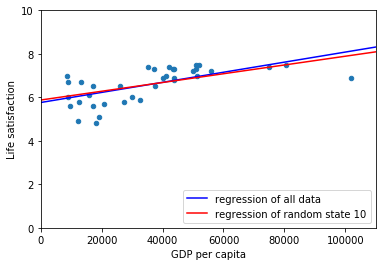

In [23]:
## Linear Regression of optimized data

model_opt_2=sklearn.linear_model.LinearRegression()
model_opt_2.fit(X_train_opt_2,y_train_opt_2)
opt_predict_2=model_opt_2.predict(X_test_opt_2)
reg_score_opt_2=model_opt_2.score(X_test_opt_2,y_test_opt_2)
reg_coef_opt_2=model_opt_2.coef_[0][0]
reg_x0_opt_2=model_opt_2.intercept_[0]

print('Predicted optimized y-test:', opt_predict_2)
print('y_test data for random state 10: ', y_test_opt_2)
print('Regression score for random state 10:', reg_score_opt_2)
print('Regresison coefficient for random state 10: ', reg_coef_opt_2)
print('x0 for for random state 10: ', reg_x0_opt_2)

full_country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction')
plt.axis([0,110000,0,10])
X_model=np.linspace(0,110000,1000)
plt.plot(X_model, reg_x0_1+X_model*reg_coef_1,"b", label='regression of all data')
plt.plot(X_model, reg_x0_opt_2+X_model*reg_coef_opt_2,"r",label='regression of random state 10')
plt.legend(loc='lower right')
plt.show()

In [20]:
# Extracting training and test data and countries which elimated during optimization process

# For random state 145

X_train_opt, X_test_opt, y_train_opt, y_test_opt, elim_count= optimal_test_score_definer(optimal_test_places, 2)

print('Optimized training GDP data: ', X_train_opt)
print('Optimized training Life Satisfaciton data: ', y_train_opt)
print('Optimized test GDP data: ', X_test_opt)
print('Optimized test Life Satisfaciton data: ', y_test_opt)
print('Eliminated Countries: ', elim_count)

Optimized training GDP data:  [[ 19121.592]
 [  9437.372]
 [ 49866.266]
 [ 15991.736]
 [ 32485.545]
 [101994.093]
 [ 12239.894]
 [  9054.914]
 [ 37675.006]
 [ 43603.115]
 [ 35343.336]
 [ 13340.905]
 [ 50854.583]
 [ 43724.031]
 [ 25864.721]
 [ 29866.581]
 [ 18064.288]
 [ 52114.165]
 [ 40106.632]
 [ 51350.744]
 [  8669.998]
 [ 74822.106]
 [  9009.28 ]
 [ 40996.511]
 [ 17256.918]
 [ 12495.334]
 [ 43770.688]
 [ 37044.891]
 [ 43331.961]
 [ 41973.988]]
Optimized training Life Satisfaciton data:  [[5.1]
 [5.6]
 [7.2]
 [6.1]
 [5.9]
 [6.9]
 [4.9]
 [6. ]
 [6.5]
 [7.3]
 [7.4]
 [6.7]
 [7.5]
 [6.9]
 [6.5]
 [6. ]
 [4.8]
 [7.5]
 [6.9]
 [7. ]
 [7. ]
 [7.4]
 [6.7]
 [7. ]
 [6.5]
 [5.8]
 [6.8]
 [7.3]
 [7.3]
 [7.4]]
Optimized test GDP data:  [[50961.865]
 [20732.482]
 [55805.204]
 [27195.197]
 [80675.308]
 [17288.083]]
Optimized test Life Satisfaciton data:  [[7.3]
 [5.7]
 [7.2]
 [5.8]
 [7.5]
 [5.6]]
Eliminated Countries:  Index(['Australia', 'Slovenia', 'United States', 'Korea', 'Switzerland',
       'Es

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:4291: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


Predicted optimized y-test: [[6.95787183]
 [6.31226655]
 [7.06131044]
 [6.45028997]
 [7.59245824]
 [6.23870494]]
Optimized y_test data::  [[7.3]
 [5.7]
 [7.2]
 [5.8]
 [7.5]
 [5.6]]
Optimized model regression score: 0.6680393984960222
Optimized model regresison coefficient:  2.1356879208453844e-05
Optimized model x0:  5.869485436494231


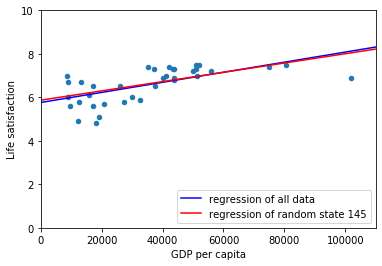

In [25]:
## Linear Regression of optimized data for random state 145

model_opt=sklearn.linear_model.LinearRegression()
model_opt.fit(X_train_opt,y_train_opt)
opt_predict=model_opt.predict(X_test_opt)
reg_score_opt=model_opt.score(X_test_opt,y_test_opt)
reg_coef_opt=model_opt.coef_[0][0]
reg_x0_opt=model_opt.intercept_[0]

print('Predicted optimized y-test:', opt_predict)
print('Optimized y_test data:: ', y_test_opt)
print('Optimized model regression score:', reg_score_opt)
print('Optimized model regresison coefficient: ', reg_coef_opt)
print('Optimized model x0: ', reg_x0_opt)

full_country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction')
plt.axis([0,110000,0,10])
X_model=np.linspace(0,110000,1000)
plt.plot(X_model, reg_x0_1+X_model*reg_coef_1,"b", label='regression of all data')
plt.plot(X_model, reg_x0_opt+X_model*reg_coef_opt,"r",label='regression of random state 145')
plt.legend(loc='lower right')
plt.show()




Predicted partial y-test: [[5.27888362]
 [5.2955476 ]
 [5.5082973 ]
 [5.70063402]
 [8.5279739 ]
 [8.81545653]
 [9.86253816]]
Partial y_test data::  [[7. ]
 [6.7]
 [6.7]
 [6.5]
 [7.4]
 [7.5]
 [6.9]]
Partial data regression score: 0.734441435543703
Partial data regresison coefficient:  4.911544589158484e-05
Partial Data x0:  4.853052800266436


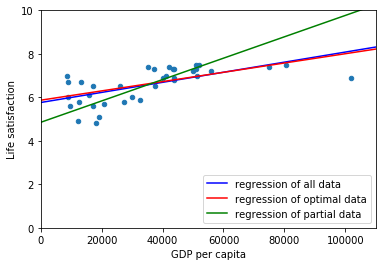

In [26]:
remove_indices = [0, 1, 6, 8, 33, 34, 35]
keep_indices = list(set(range(36)) - set(remove_indices))

partial_X_train=X[keep_indices]
parital_X_test=X[remove_indices]
partial_y_train=y[keep_indices]
partial_y_test=y[remove_indices]

model_partial=sklearn.linear_model.LinearRegression()
model_partial.fit(partial_X_train,partial_y_train)
partial_predict=model_partial.predict(parital_X_test)
reg_score_partial=model_partial.score(partial_X_train,partial_y_train)
reg_coef_partial=model_partial.coef_[0][0]
reg_x0_partial=model_partial.intercept_[0]

print('Predicted partial y-test:', partial_predict)
print('Partial y_test data:: ', partial_y_test)
print('Partial data regression score:', reg_score_partial)
print('Partial data regresison coefficient: ', reg_coef_partial)
print('Partial Data x0: ', reg_x0_partial)

full_country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction')
plt.axis([0,110000,0,10])
X_model=np.linspace(0,110000,1000)
plt.plot(X_model, reg_x0_1+X_model*reg_coef_1,"b", label='regression of all data')
plt.plot(X_model, reg_x0_opt+X_model*reg_coef_opt,"r",label='regression of optimal data')
plt.plot(X_model, reg_x0_partial+X_model*reg_coef_partial, "g", label='regression of partial data')
plt.legend(loc='lower right')
plt.show()

Predicted regularized y-test: [[5.69752694]
 [5.70844545]
 [5.8478425 ]
 [5.97386464]
 [7.82638355]
 [8.01474682]
 [8.70081168]]
Optimized y_test data::  [[7. ]
 [6.7]
 [6.7]
 [6.5]
 [7.4]
 [7.5]
 [6.9]]
Partial data regularized regression score: 0.6471340758637943
Partial data regularized regression coefficient:  3.2181236207358295e-05
Regularized Partial Data x0:  5.418515681891251


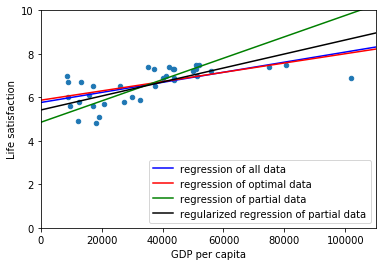

In [28]:
regular_model_partial=sklearn.linear_model.Ridge(alpha=10**9.5)
regular_model_partial.fit(partial_X_train,partial_y_train)
regular_partial_predict=regular_model_partial.predict(parital_X_test)
regular_score_partial=regular_model_partial.score(partial_X_train,partial_y_train)
regular_coef_partial=regular_model_partial.coef_[0][0]
regular_x0_partial=regular_model_partial.intercept_[0]

print('Predicted regularized y-test:', regular_partial_predict)
print('Optimized y_test data:: ', partial_y_test)
print('Partial data regularized regression score:', regular_score_partial)
print('Partial data regularized regression coefficient: ', regular_coef_partial)
print('Regularized Partial Data x0: ', regular_x0_partial)

full_country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction')
plt.axis([0,110000,0,10])
X_model=np.linspace(0,110000,1000)
plt.plot(X_model, reg_x0_1+X_model*reg_coef_1,"b", label='regression of all data')
plt.plot(X_model, reg_x0_opt+X_model*reg_coef_opt,"r",label='regression of optimal data')
plt.plot(X_model, reg_x0_partial+X_model*reg_coef_partial, "g", label='regression of partial data')
plt.plot(X_model, regular_x0_partial+X_model*regular_coef_partial, "k", label='regularized regression of partial data')
plt.legend(loc='lower right')
plt.show()